### Load Model Samples

In [1]:
print("strawberry")

# loss function and metrics
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices
from trustworthai.utils.losses_and_metrics.dice_loss_metric import DiceLossMetric, SsnDiceMeanMetricWrapper

# predefined training dataset
from trustworthai.utils.data_preprep.dataset_pipelines import load_data
from torch.utils.data import ConcatDataset

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.fitters.p_unet_fitter import PUNetLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# model
from trustworthai.run.model_load.load_ssn import load_ssn
from trustworthai.run.model_load.load_punet import load_p_unet
from trustworthai.run.model_load.load_deterministic import load_deterministic
from trustworthai.models.stochastic_wrappers.ssn.LowRankMVCustom import LowRankMultivariateNormalCustom
from trustworthai.models.stochastic_wrappers.ssn.ReshapedDistribution import ReshapedDistribution

# optimizer and lr scheduler
import torch

# misc
import argparse
import os
import shutil
import shlex
from collections import defaultdict
from tqdm import tqdm
import sys
from natsort import natsorted

print("banana")

strawberry
banana


In [2]:
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever

In [3]:
models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"

In [4]:
def construct_parser():
    parser = argparse.ArgumentParser(description = "train models")
    
    # folder arguments
    parser.add_argument('--ckpt_dir', default='s2208943/results/revamped_models/', type=str)
    parser.add_argument('--model_name', default=None, type=str)
    
    # data generation arguments
    parser.add_argument('--dataset', default='ed', type=str)
    parser.add_argument('--seed', default=3407, type=int)
    parser.add_argument('--test_split', default=0.15, type=float)
    parser.add_argument('--val_split', default=0.15, type=float)
    parser.add_argument('--empty_slice_retention', default=0.1, type=float)
    
    # model specific parameters SSN
    parser.add_argument('--ssn_rank', default=15, type=int)
    parser.add_argument('--ssn_epsilon', default=1e-5, type=float)
    parser.add_argument('--ssn_mc_samples', default=10, type=int)
    parser.add_argument('--ssn_sample_dice_coeff', default=0.05, type=float)
    parser.add_argument('--ssn_pre_head_layers', default=16, type=int)
    
    # evidential loss parameters
    parser.add_argument('--kl_factor', default=0.1, type=float)
    parser.add_argument('--kl_anneal_count', default=452*4, type=int)
    
     # model specific parameters Punet
    parser.add_argument('--kl_beta', default=10.0, type=float)
    parser.add_argument('--use_prior_for_dice', default=False, type=bool)
    parser.add_argument('--punet_sample_dice_coeff', default=0.05, type=float)
    parser.add_argument('--latent_dim', default=12, type=int)
    
    # general arguments for the loss function
    parser.add_argument('--dice_factor', default=5, type=float)
    parser.add_argument('--xent_factor', default=0.01, type=float)
    parser.add_argument('--dice_empty_slice_weight', default=0.5, type=float)
    
    # general arguments for the loss function
    parser.add_argument('--loss_name', default='dice+xent', type=str)
    # parser.add_argument('--dice_factor', default=5, type=float)
    # parser.add_argument('--xent_factor', default=0.01, type=float)
    parser.add_argument('--xent_weight', default='none', type=str)
    #parser.add_argument('--dice_empty_slice_weight', default=0.5, type=float)
    parser.add_argument('--tversky_beta', default=0.7, type=float)
    parser.add_argument('--reduction', default='mean_sum', type=str)
    
    # training paradigm arguments
    parser.add_argument('--lr', default=2e-4, type=float)
    parser.add_argument('--dropout_p', default=0.0, type=float)
    parser.add_argument('--max_epochs', default=100, type=int)
    parser.add_argument('--early_stop_patience', default=15, type=int)
    parser.add_argument('--batch_size', default=32, type=int)
    parser.add_argument('--cross_validate', default=False, type=bool)
    parser.add_argument('--cv_split', default=0, type=int)
    parser.add_argument('--cv_test_fold_smooth', default=1, type=int)
    parser.add_argument('--weight_decay', default=0.0001, type=float)
    parser.add_argument('--overwrite', default=False, type=bool)
    
    return parser

In [5]:
def load_best_checkpoint(model, loss, model_ckpt_folder, punet=False):
    # this is ultimately going to need to be passed a model wrapper when I implement P-Unet....
    
    # the path to the best checkpoint is stored as a single line in a txt file along with each model
    with open(os.path.join(model_ckpt_folder, "best_ckpt.txt"), "r") as f:
        ckpt_file = os.path.join(model_ckpt_folder, f.readlines()[0][:-1].split("/")[-1])
    
    if punet:
        return PUNetLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)
    return StandardLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)

In [6]:
def entropy_map_from_mean(mean, do_normalize=True):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    if mean.shape[1] == 1:
        raise ValueError("not implemented for implicit background class")
    else:
        assert mean.shape[1] == 2
    
    if do_normalize:
        probs = torch.nn.functional.softmax(mean, dim=1)
    else:
        probs = mean
    ent_map = torch.sum(-probs * torch.log(probs+1e-30), dim=1)

    return ent_map

In [7]:
def generate_means_and_samples_SSN_Ens(splits=6, dataset_stride=2, temp=1, num_samples=10, use_updated_scores=False):
    # load data
    clin_retriever = ClinScoreDataRetriever(use_updated_scores=use_updated_scores)
    
    # load model
    class TestArgs():
        def __init__(self, ):
            args_dict = {
                "dropout_p":0,
                "ssn_pre_head_layers":32,
                "ssn_rank":15,
                "ssn_epsilon":1e-5,
                "dice_empty_slice_weight":0.5,
                "ssn_mc_samples":10,
                "dice_factor":5,
                "xent_factor":0.01,
                "ssn_sample_dice_coeff":0.05
            }

            for key, value in args_dict.items():
                setattr(self, key, value)

    args = TestArgs()

    model_raw, loss = load_ssn(args)
    model_raw = model_raw.cuda()
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    model_base_name = "ssn_cross_validate_32_"

    model_outs = defaultdict(lambda : defaultdict(lambda : {'means':[], 'samples':[]}))

    test_datasets = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.15,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
            
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))


        for ens in range(10):
            model_name = model_base_name + f"split{split}_ens{ens}/"
            model_path = models_folder + model_name

            # with open(model_path + "best_ckpt.txt") as f:
            #     lines = f.readlines()
            #     args_lines = [l[:-1].split(": ") for l in lines[1:]]
            #     args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            #     args_line = " ".join(args_lines)
            #     parser = construct_parser()
            #     args = parser.parse_args(shlex.split(args_line))

            # load the model
            model = load_best_checkpoint(model_raw, loss, model_path)
            model.eval()


            dataskip = dataset_stride
            # means = []
            # samples = []
            for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
                if i % dataskip == 0:
                    x = data[0]
                    with torch.no_grad():
                        mean, sample = model.mean_and_sample(x.swapaxes(0,1).cuda(), num_samples=num_samples // 10, temperature=temp)

                        model_outs[split][i]['means'].append(mean.cpu())
                        model_outs[split][i]['samples'].append(sample.cpu())

                        # means.append(mean.cpu())
                        # samples.append(sample.cpu())

            #model_outs[split][ens] = {'means':means, 'samples':samples}

    for split in model_outs.keys():
        for idx in tqdm(model_outs[split].keys(), position=0, leave=True):
            model_outs[split][idx]['means'] = torch.stack(model_outs[split][idx]['means'], dim=0).mean(dim=0)
            model_outs[split][idx]['samples'] = torch.cat(model_outs[split][idx]['samples'], dim=0)

    means = [model_outs[split][idx]['means'] for split in model_outs.keys() for idx in model_outs[split].keys()]
    samples = [model_outs[split][idx]['samples'] for split in model_outs.keys() for idx in model_outs[split].keys()]

    return means, samples, ConcatDataset(test_datasets)

In [8]:
def generate_means_and_samples_SSN_Ens_Mean(splits=6, dataset_stride=2, temp=1, num_samples=10, components=10, use_updated_scores=False):
    # load data
    print("loading")
    clin_retriever = ClinScoreDataRetriever(use_updated_scores=use_updated_scores)
    print("loaded")
    
    test_datasets = []

    # load model
    class TestArgs():
        def __init__(self, ):
            args_dict = {
                "dropout_p":0,
                "ssn_pre_head_layers":32,
                "ssn_rank":15,
                "ssn_epsilon":1e-5,
                "dice_empty_slice_weight":0.5,
                "ssn_mc_samples":10,
                "dice_factor":5,
                "xent_factor":0.01,
                "ssn_sample_dice_coeff":0.05
            }

            for key, value in args_dict.items():
                setattr(self, key, value)

    args = TestArgs()

    model_raw, loss = load_ssn(args)
    model_raw = model_raw.cuda()
    model_raw.return_cpu_dist = True

    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    model_base_name = "ssn_cross_validate_32_"

    means = []
    samples = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
        )
        test_datasets.append(test_ds_clin)
        # print("size: ", len(test_ds_clin))

        dataskip = dataset_stride

        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data[0].swapaxes(0,1).cuda()
                distribution_means = []
                distribution_cov_diags = []
                distribution_cov_factors = []
                distribution_event_shapes = []

                for ens in range(components):
                    # print(ens)
                    model_name = model_base_name + f"split{split}_ens{ens}/"
                    model_path = models_folder + model_name
                    model = load_best_checkpoint(model_raw, loss, model_path)
                    model.eval()

                    with torch.no_grad():
                        mean, cov_diag, cov_factor, event_shape = model(x)
                    distribution_means.append(mean.cpu())
                    distribution_cov_diags.append(cov_diag.cpu())
                    distribution_cov_factors.append(cov_factor.cpu())
                    distribution_event_shapes.append(event_shape)

                # print(distribution_means[0].shape)

                distribution_means = torch.stack(distribution_means, dim=0).mean(dim=0)
                distribution_cov_diags = torch.stack(distribution_cov_diags, dim=0).mean(dim=0)
                distribution_cov_factors = torch.stack(distribution_cov_factors, dim=0).mean(dim=0)

                # print(distribution_means.shape)

                dist = LowRankMultivariateNormalCustom(distribution_means, distribution_cov_factors, distribution_cov_diags)
                dist = ReshapedDistribution(dist, distribution_event_shapes[0])

                means.append((dist.mean / temp).cpu())
                samples.append((model_raw._samples_from_dist(dist, num_samples=num_samples)/temp).cpu())

    return means, samples, ConcatDataset(test_datasets)

In [9]:
def generate_means_and_samples_SSN(splits=6, dataset_stride=2, temp=1, num_samples=10, independent=False, use_updated_scores=False):
    # load data
    clin_retriever = ClinScoreDataRetriever(use_updated_scores=use_updated_scores)
    
    rank = 15
    if independent:
        rank = 1
    
    # load model
    class TestArgs():
        def __init__(self, ):
            args_dict = {
                "dropout_p":0,
                "ssn_pre_head_layers":32,
                "ssn_rank":rank,
                "ssn_epsilon":1e-5,
                "dice_empty_slice_weight":0.5,
                "ssn_mc_samples":10,
                "dice_factor":5,
                "xent_factor":0.01,
                "ssn_sample_dice_coeff":0.05
            }

            for key, value in args_dict.items():
                setattr(self, key, value)

    args = TestArgs()

    model_raw, loss = load_ssn(args)
    model_raw = model_raw.cuda()
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    if independent:
        model_base_name = "ssn_ind_32_cross_validate_"
    else:
        model_base_name = "ssn_cross_validate_32_"
    ensemble_element = 0

    means = []
    samples = []

    test_datasets = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
            
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))


        if independent:
            model_name = model_base_name + f"split{split}/"
        else:
            model_name = model_base_name + f"split{split}_ens{ensemble_element}/"
        model_path = models_folder + model_name

        model = load_best_checkpoint(model_raw, loss, model_path)
        model.eval()

        dataskip = dataset_stride
        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data[0]
                with torch.no_grad():
                    mean, sample = model.mean_and_sample(x.swapaxes(0,1).cuda(), num_samples=num_samples, temperature=temp)
                    means.append(mean.cpu())
                    samples.append(sample.cpu())

    return means, samples, ConcatDataset(test_datasets)

In [10]:
def generate_means_and_samples_Ensemble(splits=6, dataset_stride=2, temp=1, num_samples=10, use_updated_scores=False):
    print("strawberry")
    # load data
    clin_retriever = ClinScoreDataRetriever(use_updated_scores=use_updated_scores)
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    model_outs = defaultdict(lambda : defaultdict(lambda : {'samples':[]}))

    test_datasets = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
            
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))


        for ens in range(10):
            model_name = f"deterministic_ens{ens}_dice+xent_split{split}/"
            model_path = models_folder + model_name

            with open(model_path + "best_ckpt.txt") as f:
                lines = f.readlines()
                args_lines = [l[:-1].split(": ") for l in lines[1:]]
                args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
                args_line = " ".join(args_lines)
                parser = construct_parser()
                args = parser.parse_args(shlex.split(args_line))
                
            model_raw, loss = load_deterministic(args)

            # load the model
            model = load_best_checkpoint(model_raw, loss, model_path)
            model.eval()



            dataskip = dataset_stride
            # means = []
            # samples = []
            for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
                if i % dataskip == 0:
                    x = data[0]
                    with torch.no_grad():
                        sample = model(x.swapaxes(0,1).cuda()).cpu()
                        sample = sample / temp
                        model_outs[split][i]['samples'].append(sample.cpu())

    for split in model_outs.keys():
        for idx in tqdm(model_outs[split].keys(), position=0, leave=True):
            model_outs[split][idx]['samples'] = torch.stack(model_outs[split][idx]['samples'], dim=0)
            model_outs[split][idx]['means'] = model_outs[split][idx]['samples'].mean(dim=0)

    means = [model_outs[split][idx]['means'] for split in model_outs.keys() for idx in model_outs[split].keys()]
    samples = [model_outs[split][idx]['samples'] for split in model_outs.keys() for idx in model_outs[split].keys()]

    return means, samples, ConcatDataset(test_datasets)

In [11]:
def generate_means_and_samples_MC_Dropout(splits=6, dataset_stride=2, temp=1, num_samples=10, use_updated_scores=False):
    print("strawberry")
    # load data
    clin_retriever = ClinScoreDataRetriever(use_updated_scores=use_updated_scores)
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    means = []
    samples = []

    test_datasets = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
            
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))
        
        model_name = f"mcdropout_dice+xent_split{split}/"
        model_path = models_folder + model_name
        with open(model_path + "best_ckpt.txt") as f:
            lines = f.readlines()
            args_lines = [l[:-1].split(": ") for l in lines[1:]]
            args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            args_line = " ".join(args_lines)
            parser = construct_parser()
            args = parser.parse_args(shlex.split(args_line))

        model_raw, loss = load_deterministic(args)
        print(args.dropout_p)

        # load the model
        model = load_best_checkpoint(model_raw, loss, model_path)

        with open(model_path + "best_ckpt.txt") as f:
            lines = f.readlines()
            args_lines = [l[:-1].split(": ") for l in lines[1:]]
            args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            args_line = " ".join(args_lines)
            parser = construct_parser()
            args = parser.parse_args(shlex.split(args_line))

        model_raw, loss = load_deterministic(args)

        # load the model
        model = load_best_checkpoint(model_raw, loss, model_path)

        dataskip = dataset_stride
        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data[0]
                with torch.no_grad():
                    model.eval()
                    mean = model(x.swapaxes(0,1).cuda()).cpu()
                    means.append(mean / temp)
                    ind_samples = []
                    model.train()
                    for j in range(num_samples):
                        sample = model(x.swapaxes(0,1).cuda()).cpu()
                        sample = sample / temp
                        ind_samples.append(sample)
                    samples.append(torch.stack(ind_samples, dim=0))

    return means, samples, ConcatDataset(test_datasets)

In [12]:
def generate_means_and_samples_PUNet(splits=6, dataset_stride=2, temp=1, num_samples=10, prior=True, on_samples=False, use_updated_scores=False):
    # load data
    clin_retriever = ClinScoreDataRetriever(use_updated_scores=use_updated_scores)
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    model_base_name = "punet_lt_"
    if prior:
        typename = "prior"
    else:
        typename = "posterior"
        
    if on_samples:
        samplesname = "on_samples_"
    else:
        samplesname = ""
        
    ensemble_element = 0

    means = []
    samples = []

    test_datasets = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
            
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))

        model_name = f"{model_base_name}{typename}_dice_{samplesname}split{split}/"
        model_path = models_folder + model_name
        
        with open(model_path + "best_ckpt.txt") as f:
            lines = f.readlines()
            args_lines = [l[:-1].split(": ") for l in lines[1:]]
            args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            args_line = " ".join(args_lines)
            parser = construct_parser()
            args = parser.parse_args(shlex.split(args_line))
        
        model_raw, loss = load_p_unet(args)
        model_raw = model_raw.cuda()

        model = load_best_checkpoint(model_raw, loss, model_path, punet=True)
        model.eval()

        dataskip = dataset_stride
        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data[0]
                y = data[1]
                with torch.no_grad():
                    model_raw(x.swapaxes(0,1).cuda(), y.cuda(), training=False)
                    mean = model_raw.sample(use_prior_mean=True).cpu() / temp
                    means.append(mean)
                    
                    ind_samples = []
                    for j in range(num_samples):
                        ind_samples.append(model_raw.sample(testing=False).cpu() / temp)
                    
                    samples.append(torch.stack(ind_samples, dim=0))

    return means, samples, ConcatDataset(test_datasets)

In [13]:
import torch.distributions as td

def generate_means_and_samples_CategoricalSoftmax(splits=6, dataset_stride=2, temp=1, num_samples=10, use_updated_scores=False):
    print("strawberry")
    # load data
    clin_retriever = ClinScoreDataRetriever(use_updated_scores=use_updated_scores)
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    means = []
    samples = []

    test_datasets = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
            
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))
        
        model_name = f"deterministic_ens0_dice+xent_split{split}/"
        model_path = models_folder + model_name
        with open(model_path + "best_ckpt.txt") as f:
            lines = f.readlines()
            args_lines = [l[:-1].split(": ") for l in lines[1:]]
            args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            args_line = " ".join(args_lines)
            parser = construct_parser()
            args = parser.parse_args(shlex.split(args_line))

        model_raw, loss = load_deterministic(args)
        print(args.dropout_p)

        # load the model
        model = load_best_checkpoint(model_raw, loss, model_path)

        with open(model_path + "best_ckpt.txt") as f:
            lines = f.readlines()
            args_lines = [l[:-1].split(": ") for l in lines[1:]]
            args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            args_line = " ".join(args_lines)
            parser = construct_parser()
            args = parser.parse_args(shlex.split(args_line))

        model_raw, loss = load_deterministic(args)

        # load the model
        model = load_best_checkpoint(model_raw, loss, model_path)

        dataskip = dataset_stride
        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data[0]
                with torch.no_grad():
                    model.eval()
                    mean = model(x.swapaxes(0,1).cuda()).cpu() / temp
                    means.append(mean)
                    dist = td.Categorical(probs = torch.softmax(mean, dim=1).moveaxis(1,-1))
                    ind_samples = []
                    samples.append(dist.sample((num_samples,)))
                    
    samples2 = []
    for s in tqdm(samples, position=0, leave=True):
        new_shape = list(s.unsqueeze(2).shape)
        new_shape[2] = 2
        new_s = torch.zeros(new_shape)
        new_s[:,:,0] = 1 - s
        new_s[:,:,1] = s
        samples2.append(new_s)
    samples = samples2

    return means, samples, ConcatDataset(test_datasets)

In [14]:
import torch.distributions as td
from trustworthai.utils.losses_and_metrics.evidential_bayes_risks import *

def generate_means_and_samples_Evidential(splits=6, dataset_stride=2, temp=1, num_samples=10, use_updated_scores=False):
    print("strawberry")
    # load data
    clin_retriever = ClinScoreDataRetriever(use_updated_scores=use_updated_scores)
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    means = []
    samples = []

    test_datasets = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
            
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))

        model_name = f"evidential_dice+xent_kl01_split{split}/"
        model_path = models_folder + model_name
        with open(model_path + "best_ckpt.txt") as f:
            lines = f.readlines()
            args_lines = [l[:-1].split(": ") for l in lines[1:]]
            args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            args_line = " ".join(args_lines)
            parser = construct_parser()
            args = parser.parse_args(shlex.split(args_line))

        model_raw, loss = load_deterministic(args)
        print(args.dropout_p)

        # load the model
        model = load_best_checkpoint(model_raw, loss, model_path)

        with open(model_path + "best_ckpt.txt") as f:
            lines = f.readlines()
            args_lines = [l[:-1].split(": ") for l in lines[1:]]
            args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            args_line = " ".join(args_lines)
            parser = construct_parser()
            args = parser.parse_args(shlex.split(args_line))

        model_raw, loss = load_deterministic(args)

        # load the model
        model = load_best_checkpoint(model_raw, loss, model_path)

        dataskip = dataset_stride
        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data[0]
                with torch.no_grad():
                    model.eval()
                    logits = model(x.swapaxes(0,1).cuda()).cpu()
                    evidence = softplus_evidence(logits)
                    alpha = get_alpha(evidence)
                    # print(alpha.shape)
                    S = get_S(alpha)
                    K = alpha.shape[1]
                    mean_p_hat = get_mean_p_hat(alpha, S)
                    means.append(mean_p_hat)
                    dist = td.Dirichlet(alpha.moveaxis(1,-1))
                    ind_samples = []
                    samples.append(dist.sample((num_samples,)).moveaxis(-1, 2))

    return means, samples, ConcatDataset(test_datasets)

In [15]:
import matplotlib.pyplot as plt
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples
from trustworthai.utils.plotting.saving_plots import save, imsave
from trustworthai.utils.print_and_write_func import print_and_write
import pandas as pd

In [16]:
#samples[0].shape

In [17]:
save_folder = "test_clinscores/results/"
results_file = save_folder + "text_results.txt"

try:
    os.mkdir(save_folder)
    os.mkdir(save_folder + "/images")
except:
    pass

with open(results_file, "w") as f:
    print_and_write(results_file, "begin results")

begin results


In [18]:
stride = 1

In [19]:
means, samples, test_datasets = generate_means_and_samples_SSN_Ens_Mean(splits=6, dataset_stride=stride, temp=1, num_samples=10, use_updated_scores=False)

loading
loaded


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [05:32<00:00,  8.31s/it]


In [20]:
len(means), len(samples)

(250, 250)

In [21]:
# softmax entropy
# ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=True) for scan_index in range(len(means))]

# evidential
# ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=False) for scan_index in range(len(means))]

# other methods
ent_maps = [entropy_map_from_samples(samples[scan_index]) for scan_index in range(len(means))]

In [22]:
samples[0].shape

torch.Size([10, 40, 2, 224, 160])

In [23]:
len(test_datasets), len(test_datasets[0])

(250, 3)

In [24]:
xs3d_test = []
ys3d_test = []
IDs = []
clin_values = []

for i, data in enumerate(test_datasets):
    if i % stride == 0:
        ys3d_test.append(data[1].squeeze())
        xs3d_test.append(data[0])
        IDs.append(data[-1]['ID'])
        clin_values.append(data[-1])

In [25]:
clin_values = pd.DataFrame.from_records(clin_values)

In [26]:
len(xs3d_test)

250

In [27]:
def plot_example(save_dir, test_datasets, means, ent_maps, scan_index, slice_index=25, stride=1):
    plt.imshow(test_datasets[scan_index * stride][0][0][slice_index],
           cmap='gray',
           vmin=None, vmax=None, origin='lower')
    plt.axis('off')
    save(save_dir, f"flair_{scan_index}_{slice_index}", is_img=True)
    
    plt.imshow(test_datasets[scan_index * stride][1][0][slice_index],
           cmap='gray',
           vmin=None, vmax=None, origin='lower')
    plt.axis('off')
    save(save_dir, f"GT_{scan_index}_{slice_index}", is_img=True)
    
    plt.imshow(means[scan_index][slice_index].argmax(dim=0),
           cmap='gray',
           vmin=None, vmax=None, origin='lower')
    plt.axis('off')
    save(save_dir, f"mean_{scan_index}_{slice_index}", is_img=True)
    
    plt.imshow(ent_maps[scan_index][slice_index],
           cmap='magma',
           vmin=0, vmax=0.7, origin='lower')
    plt.axis('off')
    save(save_dir, f"umap_{scan_index}_{slice_index}", is_img=True)

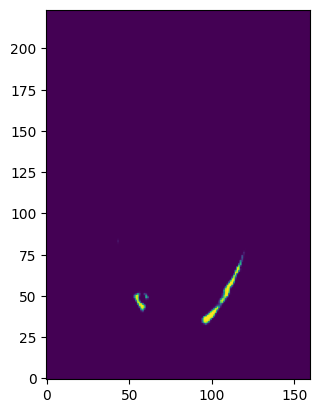

In [28]:
plt.imshow(torch.softmax(means[87][15], dim=0)[1], origin='lower')

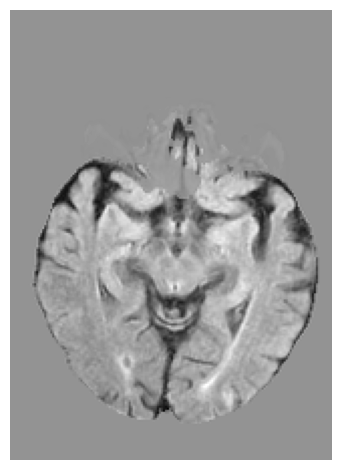

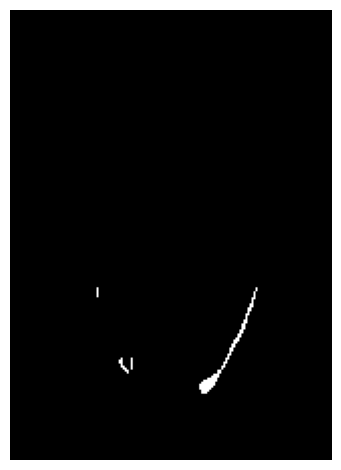

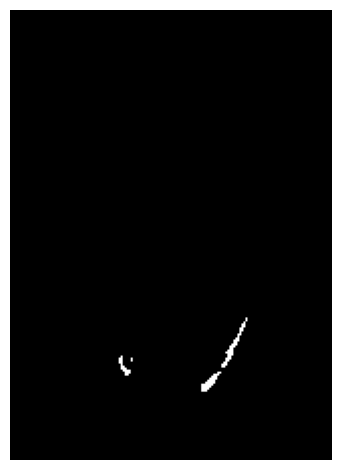

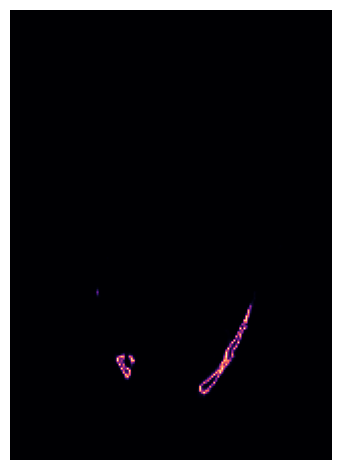

In [29]:
plot_example(save_folder, test_datasets, means, ent_maps, 87, 15)

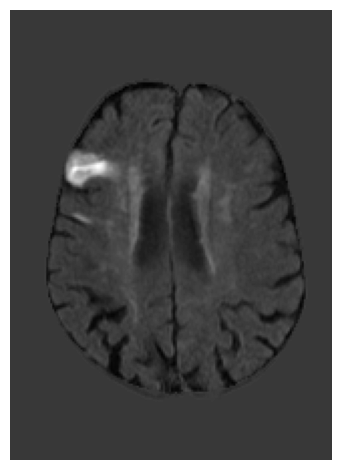

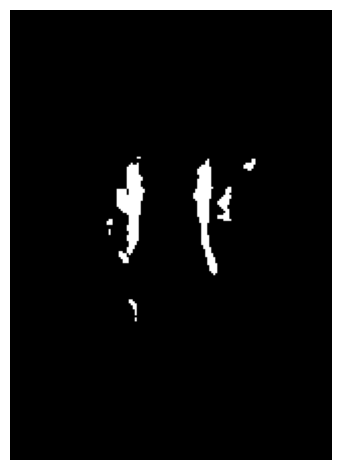

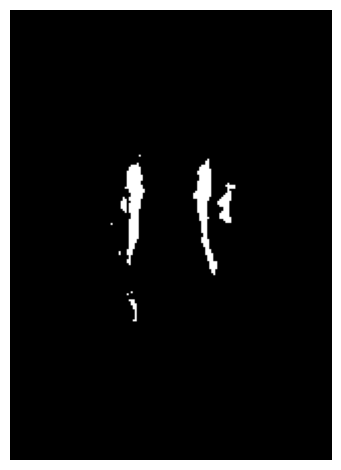

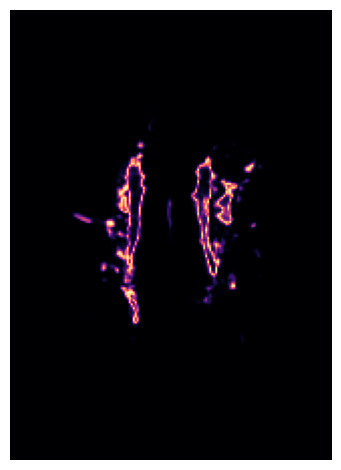

In [30]:
plot_example(save_folder, test_datasets, means, ent_maps, 1, 25)

In [31]:
# from torch.utils.data import Dataset

# class StridedDataset(Dataset):
#     def __init__(self, base_dataset, stride):
#         self.length = len(base_dataset) // stride
#         self.stride = stride
#         self.base_dataset = base_dataset
        
#     def __len__(self):
#         return self.length
    
#     def __getitem__(self, idx):
#         return self.base_dataset[idx * self.stride]

In [32]:
# dataset = StridedDataset(test_datasets, stride=2)

In [33]:
dataset = test_datasets

In [34]:
# compute the WMH and uncertianty masses
uncert_mass = []
wmh_mass = []
mean_mass = []
for i, (x, y, values) in enumerate(tqdm(dataset, position=0, leave=True)):
    uncert_mass.append(ent_maps[i].sum())
    wmh_mass.append(y.sum())
    mean_mass.append(means[i].cuda().argmax(dim=1).sum().cpu())
    
uncert_mass = torch.Tensor(uncert_mass)
wmh_mass = torch.Tensor(wmh_mass)
mean_mass = torch.Tensor(mean_mass)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 58.46it/s]


**NOTE**: okay so the mean segmentation mass on the training data is much tighter, lower variance predictor of the target, which we would expect. The uncertainty maps have a greater variance, but the nice thing here is that
actually, we see that the mass is generally predictable from predicting the wmh mass. Now we want to see if the uncertainty variance is predicted by something else.

In [35]:
import math
max_ent = -math.log(0.5)
max_ent

0.6931471805599453

In [36]:
dmg_maps = []
for i in tqdm(range(len(ent_maps)), position=0, leave=True):
    umap = ent_maps[i].cuda().clone()
    umap[means[i].cuda().argmax(dim=1) == 1] = max_ent
    dmg_maps.append(umap.cpu())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 55.37it/s]


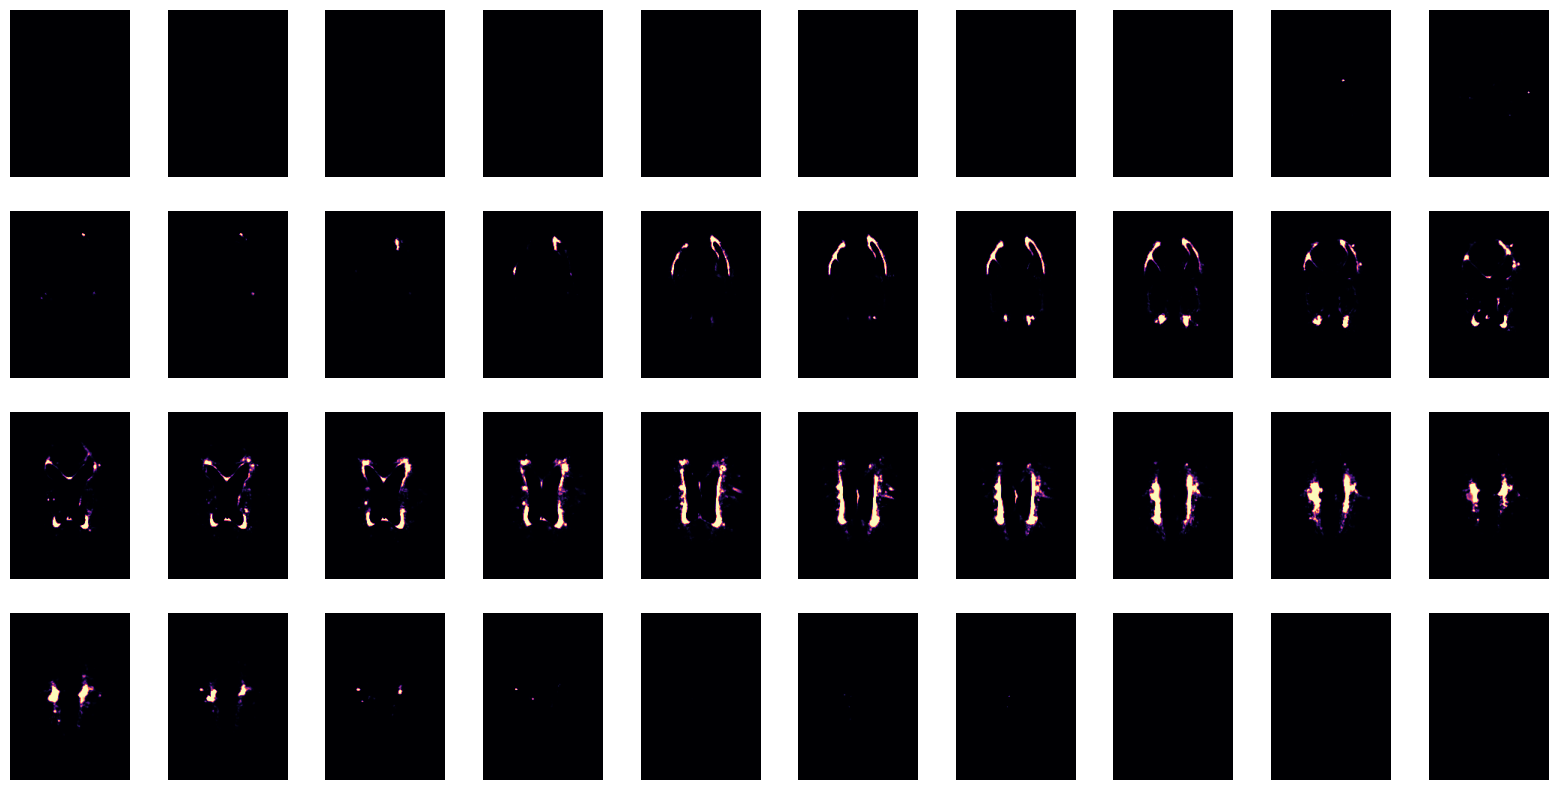

In [37]:
# plot the entropy map for the first brain scan all slices
plt.figure(figsize=(20, 10))
for i, img in enumerate(dmg_maps[0]):
    plt.subplot(4, 10, i+1)
    plt.imshow(img, vmin=0, vmax=0.7, cmap='magma')
    plt.axis('off')

In [142]:
ent_only_maps = []
for i in tqdm(range(len(ent_maps)), position=0, leave=True):
    umap = ent_maps[i].cuda().clone()
    umap[means[i].cuda().argmax(dim=1) == 1] = 0
    ent_only_maps.append(umap.cpu())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:07<00:00, 34.83it/s]


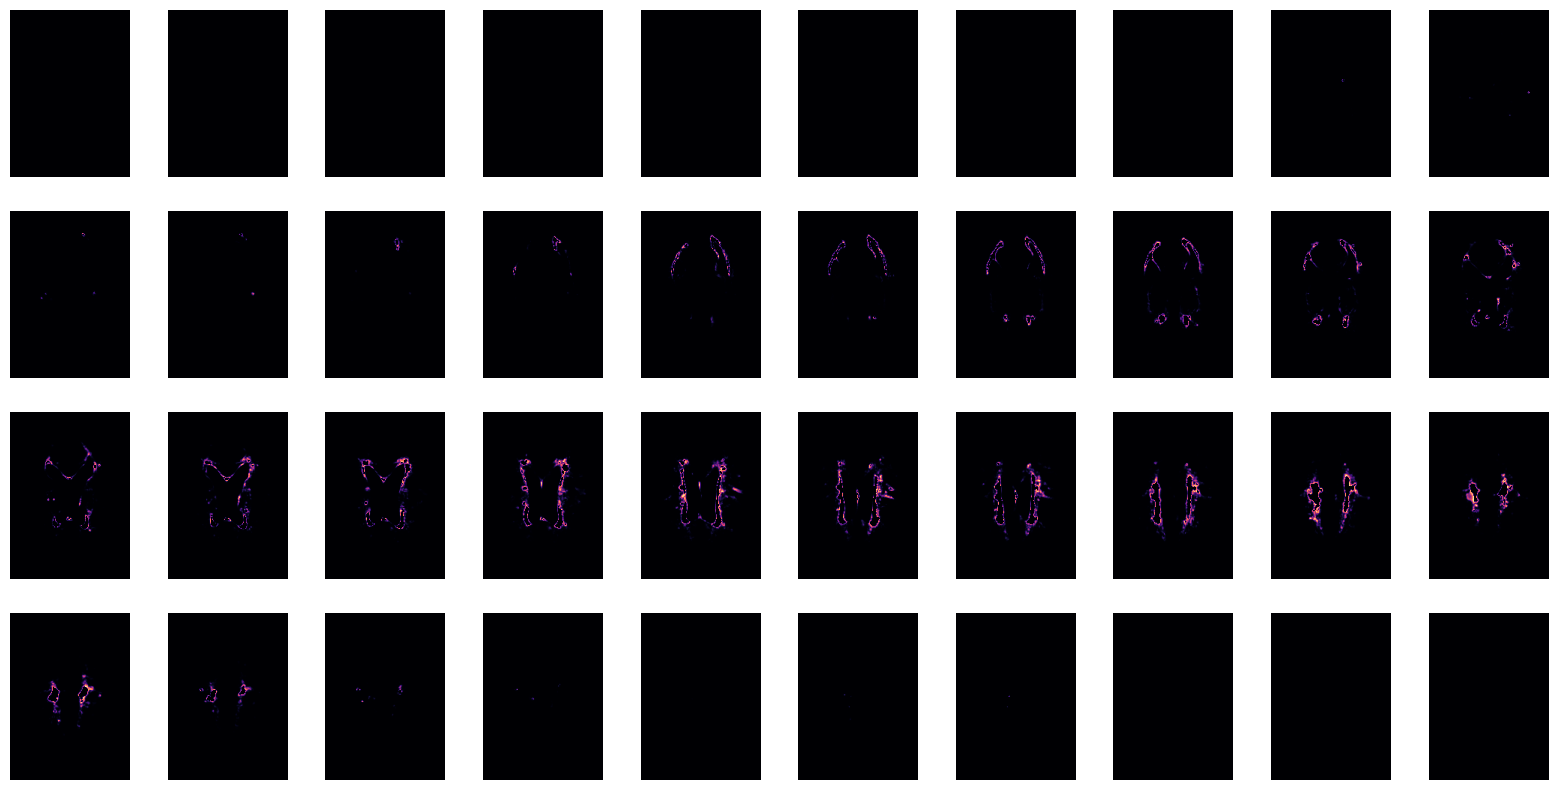

In [143]:
# plot the entropy map for the first brain scan all slices
plt.figure(figsize=(20, 10))
for i, img in enumerate(ent_only_maps[0]):
    plt.subplot(4, 10, i+1)
    plt.imshow(img, vmin=0, vmax=0.7, cmap='magma')
    plt.axis('off')

In [145]:
ent_only_vol = [eo.sum() for eo in ent_only_maps]

In [147]:
gt_vols = [yi.sum() for yi in ys3d_test]

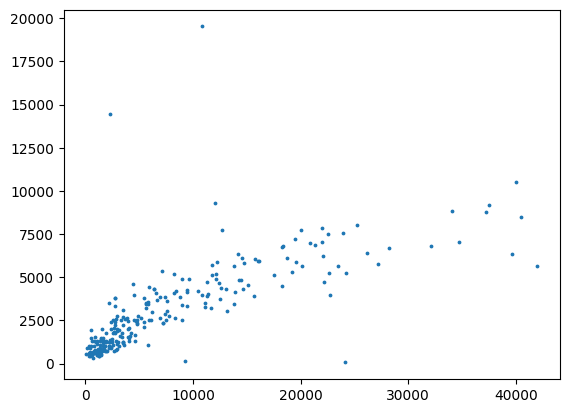

In [154]:
plt.scatter(gt_vols, ent_only_vol, s=3)
# plt.xscale('log')
# plt.yscale('log')

In [38]:
def plot_subimg(img, rows, cols, i, cmap='gray', axis='off', title='', vmin=None, vmax=None):
    plt.subplot(rows, cols, i)
    plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis(axis)
    plt.title(title)
    return i + 1

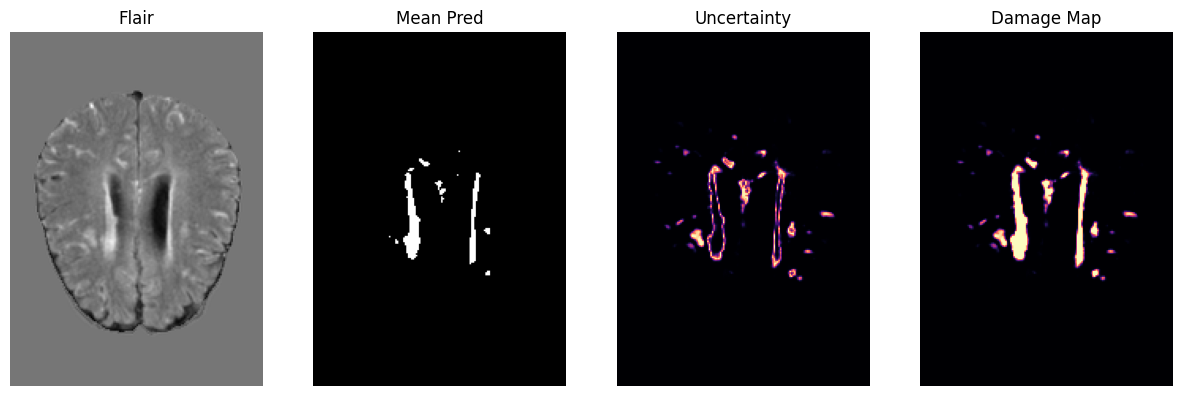

In [39]:
rows = 1
cols = 4
i = 1

plt.figure(figsize=(15, 5))
scan_id = 8
slice_id = 25
i = plot_subimg(dataset[scan_id][0][0][slice_id], rows=rows, cols=cols, i=i, title='Flair')
i = plot_subimg(means[scan_id][slice_id].argmax(dim=0), rows=rows, cols=cols, i=i, title='Mean Pred')
i = plot_subimg(ent_maps[scan_id][slice_id], rows=rows, cols=cols, i=i, title='Uncertainty', cmap='magma')
i = plot_subimg(dmg_maps[scan_id][slice_id], rows=rows, cols=cols, i=i, title='Damage Map', cmap='magma')


plt.savefig("damage_map.png")

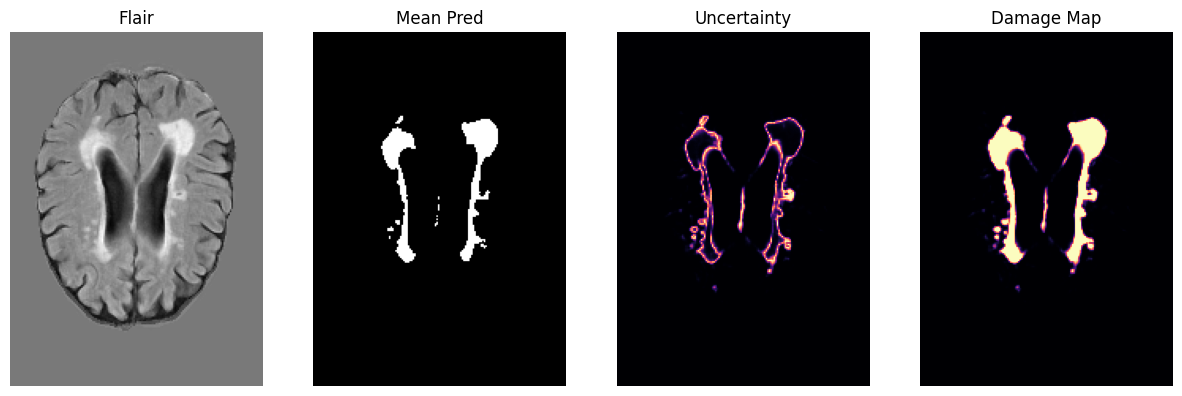

In [40]:
rows = 1
cols = 4
i = 1

plt.figure(figsize=(15, 5))
scan_id = 9
slice_id = 30
i = plot_subimg(dataset[scan_id][0][0][slice_id], rows=rows, cols=cols, i=i, title='Flair')
i = plot_subimg(means[scan_id][slice_id].argmax(dim=0), rows=rows, cols=cols, i=i, title='Mean Pred')
i = plot_subimg(ent_maps[scan_id][slice_id], rows=rows, cols=cols, i=i, title='Uncertainty', cmap='magma')
i = plot_subimg(dmg_maps[scan_id][slice_id], rows=rows, cols=cols, i=i, title='Damage Map', cmap='magma')


plt.savefig("damage_map2.png")

In [41]:
# lets just start with total uncertainty mass and wmh mass
dmg_mass = []
mean_dmg_mass = []
for i, (x, y, values) in enumerate(tqdm(dataset, position=0, leave=True)):
    # compute sum where we give the mean pred maximum entropy
    dmg_mass.append(dmg_maps[i].cuda().sum().cpu().item())
    mean_dmg_mass.append(mean_mass[i] * max_ent)
    
    
dmg_mass = torch.Tensor(dmg_mass)
mean_dmg_mass = torch.Tensor(mean_dmg_mass)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 320.95it/s]


### Computing umap metrics relative to surface area

In [42]:
class BinaryEdgeDetector2d():
    def __init__(self):
        l = torch.nn.Conv2d(1, 2, kernel_size=3, bias=False, padding=1)
        k = torch.Tensor([-1,-2,-1,0,0,0,1,2,1]).reshape((3, 3)).T
        l.weight.data[0][0] = k
        l.weight.data[1][0] = (k*-1).T
        l = l.cuda()
        self.l = l
        
    def __call__(self, x):
        x = x.cuda()
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        if x.shape[1] > 1:
            raise ValueError("edge detector expects a 1 channel binary mask")
        x = x.type(torch.float32)
        
        with torch.no_grad():
            edge = self.l(x)
            edge = edge.abs()
            edge = (edge[:,0] > 0) | (edge[:,1] > 0)
            edge = edge.cpu()
            return edge

In [43]:
edge_detector = BinaryEdgeDetector2d()
surface_area = []
for m in tqdm(means, position=0, leave=True):
    surface_area.append(edge_detector(m.cuda().argmax(dim=1)).sum().cpu().item())
    
surface_area = torch.Tensor(surface_area)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:02<00:00, 88.29it/s]


### Considering the slice by slice effect
The increase in uncertainty at a specific slice / set of slices may be overshadowed by the overall volume
so instead, I could look at per-slice behaviour?
I could look at the distribution over the slices of ratio of dmg to the mean or surface area...
or I could store the maximum difference per slice, this could be an interesting analysis... (then you would likely capture the highest uncertainty at the slice where the
stroke lesion is most present...)

**NOTE**: also, remembre the image (in val set) where the model segments a 'hook' shape in the top right hand side, but misses much of the lesion on both sides middle of the brain. There is an image like this in the validation data that doesn't have these lesions it seems also... so perhaps it is a common shape and the model has overfitted to it in some way?

In [44]:
# right, so slice by slice effects. one thing we could do is compute the maximum difference divided by the surface area in that slice.
# also the intensity damage score that maria uses I need to look at this....

slice_dmgs = []
max_slice_dmgs = []

for i in tqdm(range(len(means)), position=0, leave=True):
    m = means[i].cuda().argmax(dim=1)
    m_mass = m.sum(dim=(1,2)) * max_ent
    d_mass = dmg_maps[i].cuda().sum(dim=(1,2))
    sa = edge_detector(m).sum(dim=(1,2)).cuda()
    
    # per slice differences
    slice_diff = (d_mass - m_mass) / sa
    slice_diff[slice_diff == torch.inf] = 0
    slice_diff = slice_diff.cpu()
    
    slice_dmgs.append(slice_diff)
    max_slice_dmgs.append(slice_diff.max().item())


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 37.71it/s]


### Looking at the output of fast results (used for computing damage score)

In [45]:
import torchvision as tv
from twaidata.MRI_preprep.resample import resample_and_return, get_resampled_img
from natsort import natsorted
import nibabel as nib
from collections import defaultdict

In [46]:
fast_folder = "/home/s2208943/ipdis/data/preprocessed_data/Ed_fast_WM_masks/"

In [47]:
# output of fast results:
# we have to resample the image first
fnames = [name for name in natsorted(os.listdir(fast_folder)) if (".nii.gz" in name and "_T1_BET_" in name and ("pveseg" in name or "pve_2" in name))]
fnames = natsorted(fnames)

# the old way that I was loading the images, its bad because the resampling isn't done so the masks don't line up!
# imgs = []
# # this takes a couple of minutes as it is loading from the dfs
# for name in tqdm(fnames, position=0, leave=True):
#      imgs.append(np.array(nib.load(fast_folder+name).dataobj))

In [48]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os

# resamples an image
def get_resampled_img(itk_image, out_spacing=[2.0, 2.0, 2.0], original_spacing=[1., 1., 3.], is_label=False):
    
    if not original_spacing:
        # orig spacing can be specified when the input itk_image does not know its actual spacing.
        original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    # what's this? its how to modify the output size I think...
    out_size = [
        int(np.round(orig_size * orig_spacing / out_spacing))
        for (orig_size, orig_spacing, out_spacing) 
        in zip(original_size, original_spacing, out_spacing)
    ]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())      # sets the output direction cosine matrix...
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
        
    return resample.Execute(itk_image)
      
def resample_and_return(filename_in, is_label=False, out_spacing=[1., 1., 3.], original_spacing=None):
    """
    resamples an image to custom voxel dimensions and returns image as a numpy array
    
    filename_in: .nii.gz file to load
    is_label: is the file a brain scan or a segmentaion mask
    outspacing: the spacing of the image to be resampled to.
    """
        
    # resample the image
    image = sitk.ReadImage(filename_in)
    resampled_image = get_resampled_img(image, out_spacing=out_spacing, original_spacing=original_spacing, is_label=is_label)
    
    return sitk.GetArrayFromImage(resampled_image)

In [49]:
# this loop takes a while as its loading from disk and resampling
# it takes around 11 minutes

cropper = tv.transforms.CenterCrop((224, 160))

def load_fast_output(file, slices):
    timg = resample_and_return(file, is_label=True)
        
    # interpolate the channel number and centre crop
    timg = torch.Tensor(timg)
    timg = torch.nn.functional.interpolate(timg.unsqueeze(0).unsqueeze(0), (slices, *timg.shape[1:])).squeeze()
    timg = cropper(timg.view((1, 1, *timg.shape))).squeeze()
    
    return timg



In [50]:
# individual example
pos = 8
ID = IDs[pos]
num_slices = dataset[pos][0].shape[1]

sel_files = [f for f in natsorted(os.listdir(fast_folder)) if ID in f and "_T1_BET_" in f]

In [51]:
xs3d_test[pos].shape

torch.Size([3, 40, 224, 160])

In [52]:
sel_files

['CVD052_T1_BET_mixeltype.nii.gz',
 'CVD052_T1_BET_pve_0.nii.gz',
 'CVD052_T1_BET_pve_1.nii.gz',
 'CVD052_T1_BET_pve_2.nii.gz',
 'CVD052_T1_BET_pveseg.nii.gz',
 'CVD052_T1_BET_seg.nii.gz']

In [53]:
individual_fast_examples = [load_fast_output(fast_folder + f, num_slices) for f in sel_files]

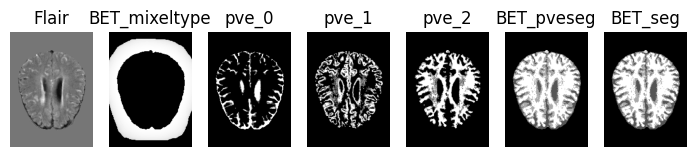

In [54]:
slice_id = 25
scan_id = pos
i = 1
rows = 1
cols = 8
plt.figure(figsize=(10, 3))
i = plot_subimg(dataset[scan_id][0][0][slice_id], rows=rows, cols=cols, i=i, title='Flair')
for j, img in enumerate(individual_fast_examples):
    i = plot_subimg(img[slice_id], rows=rows, cols=cols, i=i, title="_".join(sel_files[j].split(".")[0].split("_")[-2:]))

***NOTE:*** so, I can use the binary segmentation, use pveseg == 2, or I can use the WM probability map. Lets look at what the flair * these values would look like
(and then what the flair * confidence map, * the ent map, * the damage map and * the hard mean segmentation would look like.
One thing I can also try is setting a baseline threshold for the uncertianty (cutting off anything outside that uncertainty), otherwise there will be a lot of voxels at low volume adding in to the uncertianty, (I should also set it to zero outside the mask I guess.)

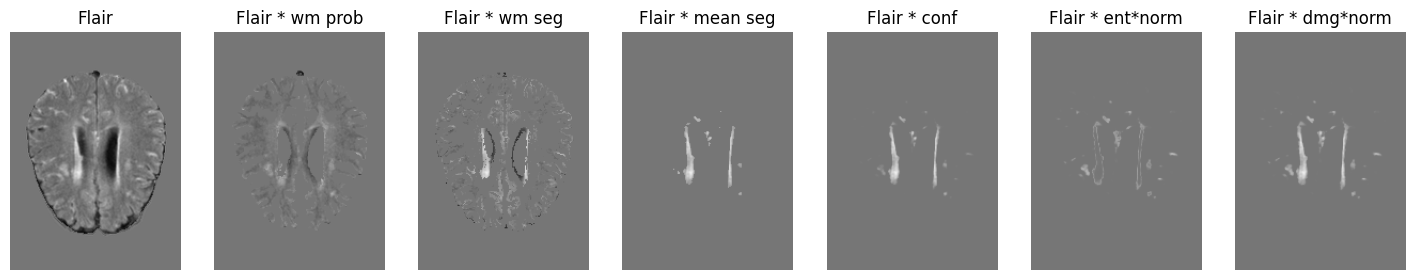

In [55]:
rows = 1
cols = 7
i = 1
scan_id = pos
slice_id = 25


plt.figure(figsize=(18, 5))
# flair
flair = dataset[scan_id][0][0][slice_id]
vmin = flair.min()
vmax = flair.max()
i = plot_subimg(flair, rows=rows, cols=cols, i=i, title='Flair', vmin=vmin, vmax=vmax)

# flair * fast wm probability distribution
i = plot_subimg(flair * individual_fast_examples[3][slice_id], rows=rows, cols=cols, i=i, title='Flair * wm prob', vmin=vmin, vmax=vmax)

# flair * fast wm hard seg
i = plot_subimg(flair * (individual_fast_examples[-1][slice_id]==2), rows=rows, cols=cols, i=i, title='Flair * wm seg', vmin=vmin, vmax=vmax)

# flair * wm mean seg conf (note that the output between the two classes is not entirely the same)
i = plot_subimg(flair * means[scan_id].argmax(dim=1)[slice_id], rows=rows, cols=cols, i=i, title='Flair * mean seg', vmin=vmin, vmax=vmax)

# flair * the mean conf
i = plot_subimg(flair * torch.nn.functional.softmax(means[scan_id], dim=1)[slice_id, 1], rows=rows, cols=cols, i=i, title='Flair * conf', vmin=vmin, vmax=vmax)
#plt.colorbar()

# flair * the ent map
ent_norm_factor = 1/max_ent
i = plot_subimg(flair * (ent_maps[scan_id][slice_id]*ent_norm_factor), rows=rows, cols=cols, i=i, title='Flair * ent*norm', vmin=vmin, vmax=vmax)
#plt.colorbar()

# flair * dmg map
i = plot_subimg(flair * (dmg_maps[scan_id][slice_id]*ent_norm_factor), rows=rows, cols=cols, i=i, title='Flair * dmg*norm', vmin=vmin, vmax=vmax)
#plt.colorbar()

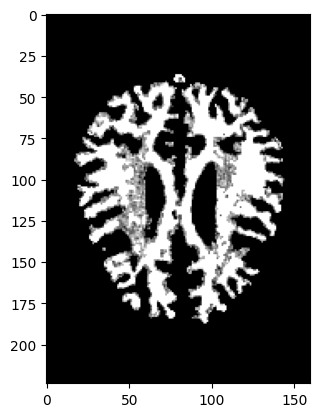

In [56]:
plt.imshow(individual_fast_examples[3][25], cmap='gray');
# example of the white matter segmentation

In [57]:
individual_fast_examples[4].min()

tensor(0.)

### Clinscores Analysis

In [58]:
import nibabel as nib

In [59]:
import trustworthai

### Loading the fast images for each scan
need to load the pve_2 and the pve_seg files (but need to ask maria the difference between pve_seg and seg)

In [60]:
fast_imgs = defaultdict(lambda: {})

for pos in tqdm(range(len(dataset)), position=0, leave=True):
    # get target image named
    ID = IDs[pos]
    locs = [i for i in range(len(fnames)) if ID in fnames[i]]
    selected_fnames = [fnames[i] for i in locs]
    
    target_shape = dataset[pos][0][0].shape
    num_slices = target_shape[0]
    
    for name in selected_fnames:
        # resample the image (should have done this during the preprocess)
        timg = load_fast_output(fast_folder + name, num_slices)
        
        fast_imgs[ID][name] = timg

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:01<00:00,  4.08it/s]


In [61]:
#pos = 8
ID = IDs[pos]
flair = dataset[pos][0][0]

imgs = list(fast_imgs[ID].values())
keys = list(fast_imgs[ID].keys())

In [62]:
for i, v in enumerate(IDs):
    if v == "CVD002":
        print(i)
        break

225


In [63]:
keys

['CVD103_T1_BET_pve_2.nii.gz', 'CVD103_T1_BET_pveseg.nii.gz']

In [64]:
means[225].shape

torch.Size([48, 2, 224, 160])

### Loading the ventricle segmentation

In [65]:
# example CVD001 image computed
example_vent_file = "/home/s2208943/ipdis/data/core_data/EdData/CVD002/masks/ventmapper_seg.nii.gz"

In [66]:
img = sitk.ReadImage(example_vent_file)

In [67]:
sitk.GetArrayFromImage(img).shape

(80, 256, 256)

In [68]:
img.GetSpacing()

(1.0, 1.0, 2.0)

In [69]:
t1 = "/home/s2208943/ipdis/data/core_data/EdData/CVD002/MRI/FLAIR.nii.gz"

In [70]:
t1 = sitk.ReadImage(t1)

In [71]:
t1.GetSpacing()

(1.0, 1.0, 2.0)

In [72]:
sitk.GetArrayFromImage(t1).shape

(80, 256, 256)

In [73]:
vent_map = load_fast_output(example_vent_file, 48)

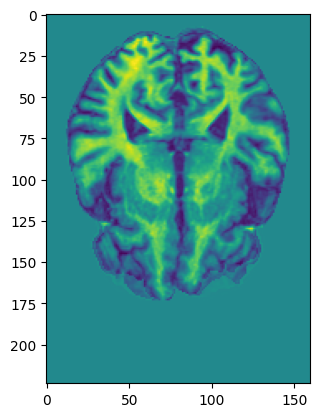

In [74]:
plt.imshow(xs3d_test[225][2][27])

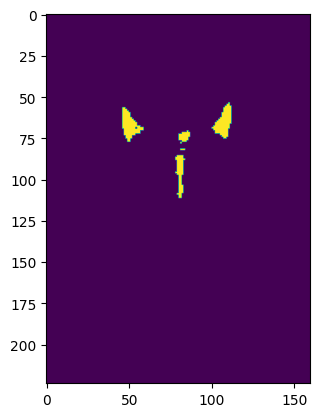

In [75]:
plt.imshow(vent_map[26])

### Computing the damage scores in various guises, normalized and un-normalized

when computing the damage score, I could threshold the uncertainty, or I could try multiplying the intensities by the uncertainty threshold, those that are outside the mean segmentaion..?
Or, I could take any pixel with uncertainty > 0.01 and multiply it by the uncertainty when contributing it to the damage score in some way...? Interesting... I need to ensure the uncertainty damage score is always greater than the WMH damage score?
or I could try one where the uncertainty damage score can be theoretically less?

In [76]:
max_ent

0.6931471805599453

In [77]:
# new damage score functions
def normalize01_scale(img):
    return (img - img.min()) / (img.max() - img.min())

def damage_score_thresholded(flair, wmh_mask, wm_mask, brain_mask, normalize_flair=True):
    if normalize_flair:
        flair = normalize01_scale(flair)
        
    wm_voxels = flair[(wm_mask == 1) & (wmh_mask != 1) & (brain_mask==1)]
    wmh_voxels = flair[(wmh_mask == 1) & (brain_mask==1)]
    
    I_wm = wm_voxels.mean().item()
    I_wmh = wmh_voxels.mean().item()
    
    vol_wm = wm_voxels.shape[0]
    vol_wmh = wmh_voxels.shape[0]
    
    try:
        damage = ((I_wmh - I_wm) / I_wm) * (vol_wmh / (vol_wmh + vol_wm))
    
        return damage
    except:
        return torch.nan
    
    
def damage_score_probabilistic2(flair, wmh_map, wm_map, brain_mask, normalize_flair=True, min_threshold=0.01, bias=1):
    if normalize_flair:
        flair = normalize01_scale(flair)
        
    wm_prob_weighted = (wm_map * flair)[(wm_map > min_threshold) & (wmh_map < min_threshold) & (brain_mask==1)]
    # wm_prob_weighted = (wm_map * flair)[(wm_map > min_threshold)]# & (brain_mask==1)]
    wmh_prob_weighted = (wmh_map * flair)[(wmh_map > min_threshold) & (brain_mask==1)]
    
    I_wm = wm_prob_weighted.mean()
    I_wmh = wmh_prob_weighted.mean()
    
    vol_wm = wm_map.sum()
    vol_wmh = wmh_map.sum()
    
    try:
        damage = ((I_wmh - I_wm) / I_wm) * (vol_wmh / (vol_wmh + vol_wm)) + bias
    
        return damage.item()
    except:
        return torch.nan
    
    return damage

def damage_score_probabilistic(flair, wmh_map, wm_map, brain_mask, normalize_flair=True, min_threshold=0.01, bias=1):
    if normalize_flair:
        flair = normalize01_scale(flair)
        
    wm_prob_weighted = (wm_map * flair)[(wm_map > min_threshold) & (wmh_map < min_threshold) & (brain_mask==1)]
    wmh_prob_weighted = (wmh_map * flair)[(wmh_map > min_threshold) & (brain_mask==1)]
    
    I_wm = wm_prob_weighted.mean()
    I_wmh = wmh_prob_weighted.mean()
    
    vol_wm = wm_map.sum()
    vol_wmh = wmh_map.sum()
    
    try:
        damage = ((I_wmh - I_wm) / I_wm) * (vol_wmh / (vol_wmh + vol_wm)) + bias
    
        return damage.item()
    except:
        return torch.nan
    
    return damage

In [78]:
import pandas as pd
# the damage scores that we can compute:
# threshold the uncertainty at different levels, 0.01, 0.1, 0.2, 0.3, 0.4
# or a different damage metric where we increase the volume of the WMH using the uncertainty map
# we don't change the IWMH (as it highlights a greater background area which has lower uncertainty
# but it also highlights it with different levels of uncertainty which we want to be sensitive too

# okay, to build all my damage scores, I have the following to do:
# build the filters for each image
# do the 5 types of damage score.
# compute this for each image. Then we are ready to get modelling.

uncert_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
min_prob_thresh = 0.3
bias=0
norm_name = 'norm_' # set to '' for model training

def generate_damage_scores(uncert_thresholds, normalize):
    rows = []
    norm_string =  ''#norm_name if normalize else ''
    

    for pos in tqdm(range(len(dataset)), position=0, leave=True):
        row = {}
        
        # get target image named
        ID = IDs[pos]
        row['ID'] = ID

        flair = dataset[pos][0][0].cuda()
        mask = dataset[pos][0][1].cuda()
        wmh = means[pos].cuda()
        
        # zero the dmg and ent maps outside the mask (I forgot to do it earlier oops)
        # and normalize them to 0-1 entropy range
        ent_normalizer = 1/max_ent
        dmg_map = dmg_maps[pos].cuda() * mask * ent_normalizer
        ent_map = ent_maps[pos].cuda() * mask * ent_normalizer

        # build the 'nawm' (as maria is defining it?) mask options
        fast_map = fast_imgs[ID]
        wm_map = fast_map[ID + "_T1_BET_pve_2.nii.gz"].cuda()
        wm_seg = fast_map[ID + "_T1_BET_pveseg.nii.gz"].cuda() == 3 # 0 = fast brain mask (is it different to bet?), 1 = csf, 2 = gray, 3 = white

        # compute the soft damage scores for mean conf, umap, dmg_map,
        row[f"mean_{norm_string}dmg"] = damage_score_probabilistic(flair, torch.nn.functional.softmax(wmh, dim=1)[:,1], wm_map, mask, normalize_flair=normalize, min_threshold=min_prob_thresh, bias=bias)
        row[f"ent_{norm_string}dmg"] = damage_score_probabilistic(flair, ent_map, wm_map, mask, normalize_flair=normalize, min_threshold=min_prob_thresh, bias=bias)
        row[f"comb_{norm_string}dmg"] = damage_score_probabilistic(flair, dmg_map, wm_map, mask, normalize_flair=normalize, min_threshold=min_prob_thresh, bias=bias)
        
        # hard damage score for mean
        row[f"mean_thresh_{norm_string}dmg"] = damage_score_thresholded(flair, wmh.argmax(dim=1), wm_seg, mask, normalize_flair=normalize)
        
        # hard damage score for uncertainty maps at varying thresholds
        for t in uncert_thresholds:
            row[f"ent>{t}_thresh_{norm_string}dmg"] = damage_score_thresholded(flair, ent_map > (t*ent_normalizer), wm_seg, mask, normalize_flair=normalize)
            row[f"comb>{t}_thresh_{norm_string}dmg"] = damage_score_thresholded(flair, dmg_map > (t*ent_normalizer), wm_seg, mask, normalize_flair=normalize)
        
        rows.append(row)
    
    return rows

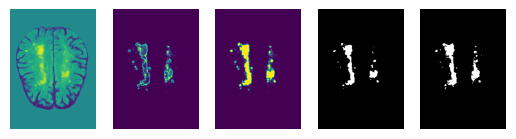

In [79]:

scan_id = 96
slice_id = 32
plt.subplot(1, 5, 1)
plt.imshow(dataset[scan_id][0][0][slice_id]); plt.axis('off')
plt.subplot(1, 5, 2)
plt.imshow(ent_maps[scan_id][slice_id]); plt.axis('off')
plt.subplot(1, 5, 3)
plt.imshow(dmg_maps[scan_id][slice_id]); plt.axis('off')
plt.subplot(1, 5, 4)
plt.imshow(means[scan_id][slice_id].argmax(dim=0), cmap='gray'); plt.axis('off')
plt.subplot(1, 5, 5)
plt.imshow(ys3d_test[scan_id][slice_id], cmap='gray'); plt.axis('off');

In [80]:
dmg_rows = generate_damage_scores(uncert_thresholds, normalize=False)
dmg_df = pd.DataFrame(dmg_rows)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:20<00:00, 12.11it/s]


In [81]:
dmg_norm_rows = generate_damage_scores(uncert_thresholds, normalize=True)
dmg_norm_df = pd.DataFrame(dmg_norm_rows)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:15<00:00, 15.88it/s]


In [82]:
dmg_df

,ID,mean_dmg,ent_dmg,comb_dmg,mean_thresh_dmg,ent>0.1_thresh_dmg,comb>0.1_thresh_dmg,ent>0.2_thresh_dmg,comb>0.2_thresh_dmg,ent>0.3_thresh_dmg,comb>0.3_thresh_dmg,ent>0.4_thresh_dmg,comb>0.4_thresh_dmg,ent>0.5_thresh_dmg,comb>0.5_thresh_dmg
0,CVD152,0.122008,0.051537,0.171933,0.110677,0.121050,0.182963,0.083199,0.159039,0.061865,0.146068,0.046559,0.136759,0.033747,0.129464
1,CVD023,0.172971,0.065500,0.235645,0.152625,0.145274,0.240556,0.100234,0.214093,0.073807,0.197600,0.056057,0.186168,0.040837,0.176408
2,CVD008,0.691117,0.357601,1.071769,0.648618,0.808290,1.192521,0.544946,1.037723,0.404261,0.947610,0.298963,0.876263,0.216231,0.815533
3,CVD141,0.033947,0.024382,0.057249,0.030395,0.053603,0.066051,0.036672,0.053212,0.027560,0.046567,0.020594,0.042176,0.015134,0.038901
4,CVD041,0.524865,0.098133,0.665537,0.467371,0.220233,0.637504,0.151905,0.595372,0.115173,0.568254,0.087081,0.546792,0.063887,0.527325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,CVD289,0.046897,0.022749,0.071880,0.041201,0.058743,0.085370,0.036139,0.067126,0.025553,0.058572,0.018790,0.053366,0.013360,0.049757
246,CVD318,0.157125,0.063182,0.222338,0.148132,0.154321,0.255120,0.106389,0.221081,0.079153,0.201618,0.059614,0.188142,0.044362,0.177012
247,CVD302,0.013313,0.015457,0.027423,0.012699,0.032136,0.036061,0.021324,0.026669,0.015684,0.022473,0.011763,0.019622,0.008328,0.017246
248,CVD279,0.016740,0.013585,0.030883,0.016156,0.030052,0.036897,0.020495,0.029055,0.015652,0.025411,0.011518,0.022733,0.008131,0.020825


In [83]:
dmg_norm_df

,ID,mean_dmg,ent_dmg,comb_dmg,mean_thresh_dmg,ent>0.1_thresh_dmg,comb>0.1_thresh_dmg,ent>0.2_thresh_dmg,comb>0.2_thresh_dmg,ent>0.3_thresh_dmg,comb>0.3_thresh_dmg,ent>0.4_thresh_dmg,comb>0.4_thresh_dmg,ent>0.5_thresh_dmg,comb>0.5_thresh_dmg
0,CVD152,0.016580,-0.000391,0.023898,0.015432,0.016346,0.024361,0.011491,0.021519,0.008652,0.019928,0.006571,0.018767,0.004798,0.017846
1,CVD023,0.019107,0.000904,0.026642,0.016437,0.015216,0.024800,0.010713,0.022359,0.007989,0.020817,0.006119,0.019727,0.004492,0.018786
2,CVD008,0.023876,-0.000336,0.040470,0.025515,0.027381,0.037527,0.020394,0.034733,0.016060,0.032904,0.012449,0.031349,0.009365,0.029925
3,CVD141,0.004429,-0.000421,0.007624,0.004472,0.007746,0.009494,0.005358,0.007715,0.004050,0.006781,0.003040,0.006159,0.002242,0.005693
4,CVD041,0.058911,0.001316,0.077436,0.046187,0.023703,0.057479,0.017057,0.054924,0.013243,0.053202,0.010198,0.051790,0.007595,0.050469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,CVD289,0.007592,-0.000966,0.010638,0.006576,0.009176,0.013204,0.005730,0.010514,0.004081,0.009231,0.003016,0.008443,0.002152,0.007892
246,CVD318,0.018120,-0.002072,0.025106,0.018475,0.018461,0.029639,0.013126,0.026297,0.009943,0.024303,0.007584,0.022884,0.005703,0.021692
247,CVD302,0.000422,-0.000774,0.000803,0.000752,0.001880,0.002105,0.001257,0.001567,0.000928,0.001324,0.000698,0.001158,0.000495,0.001019
248,CVD279,0.001348,-0.001301,0.002444,0.001871,0.003442,0.004216,0.002363,0.003339,0.001810,0.002927,0.001335,0.002623,0.000945,0.002405


In [155]:
# adding derived fields
other_scores_df = {}
other_scores_df['ID'] = IDs
other_scores_df["wmh_gt_vol"] = wmh_mass * 0.003
other_scores_df["mean_vol"] = mean_mass * 0.003
other_scores_df["uncert_vol"] = uncert_mass * 0.003
other_scores_df["comb_vol"] = dmg_mass * 0.003
other_scores_df["(comb-mean_scaled)/surface_area"] = (dmg_mass - mean_dmg_mass)/surface_area
other_scores_df["(dmg-mean_scaled)"] = (dmg_mass - mean_dmg_mass) * 0.003
other_scores_df["max slice (comb-mean_s)/sa"] = max_slice_dmgs
other_scores_df['ent_only_sum'] = ent_only_vol
other_scores_df = pd.DataFrame(other_scores_df)

In [156]:
all_dmg_scores = pd.concat([other_scores_df, dmg_norm_df, dmg_df], join='outer', axis=1)

In [86]:
all_dmg_scores.iloc[0]

ID                                    CVD152
wmh_gt_vol                            26.421
mean_vol                              22.836
uncert_vol                          17.82616
comb_vol                           27.458708
(comb-mean_scaled)/surface_area     0.362984
(dmg-mean_scaled)                  11.629998
max slice (comb-mean_s)/sa          0.548064
ID                                    CVD152
mean_dmg                             0.01658
ent_dmg                            -0.000391
comb_dmg                            0.023898
mean_thresh_dmg                     0.015432
ent>0.1_thresh_dmg                  0.016346
comb>0.1_thresh_dmg                 0.024361
ent>0.2_thresh_dmg                  0.011491
comb>0.2_thresh_dmg                 0.021519
ent>0.3_thresh_dmg                  0.008652
comb>0.3_thresh_dmg                 0.019928
ent>0.4_thresh_dmg                  0.006571
comb>0.4_thresh_dmg                 0.018767
ent>0.5_thresh_dmg                  0.004798
comb>0.5_t

In [87]:
#all_dmg_scores.to_excel("CVD_dmg_scores.xlsx")

### Checking the umaps can still be used to predict fazekas 3 for example

In [157]:
"""AUX FUNCTIONS"""

def convert_symbol_to_nan(df, field, symbol):
    df = df.copy()
    """
    converts all inputs conforming to 'symbol' to np.nan for the given 'field' in the 'df'
    e.g if symbol=' ' and field='totalChl' then any instances of ' ' in the 'totalChl' column will be replaced with np.nan
    """
    values = df[field].values
    locs = values == symbol
    values[locs] = np.nan
    
    df[field] = values
    
    return df

def filter_rows_with_nans(df, field, inplace=False):
    """
    removes all rows from df which have nan for the given field value
    """
    values = df[field].values
    nan_locs = np.where(np.isnan(values))[0]
    df = df.drop(nan_locs, inplace=inplace)
    df = df.reset_index(drop=True)
    
    return df
    
    
def one_hot_encode(df, field, remove_original=True):
    """computes a one hot encoding of the given field"""
    
    onehot_cols = pd.get_dummies(df[field], prefix=field)
    
    if remove_original:
        df = df.drop(columns=[field], inplace=False)
        
    df = pd.concat([df, onehot_cols], axis=1)
    
    return df
    
    

In [158]:
def preprep_clinscores(
    df,
    fields,
    inc_brain_scores=False,
    nan_filter_dict = {'hyperlipidaemia': 'row', 'smoking':'row', 'SBP':'row', 'DBP':'row', 'MMSE':'col', 'relLes':'row'},
    other_fields_policy = 'row',
    relLes_default = 0,
    one_hot_fields = None,
    remove_one_hot_originals = True,
    log_fields = None,
    normalize_fields = None
    ):
    
    """
    fields: a list of fields to keep in preprocessed table.
    
    inc_brain_scores: <True, False> includes the following fields, which are otherwise missing collectively in multiple rows: PVWMH, DWMH, deepAtrophy, supAtrophy, BGPVS, CSPVS, oldLes, relLes
        if true rows missing these values are skipped
        if false, the column entirely is skipped.
    
    nan_filter_dict: {key: <'row', 'col', None>} a dictionary of field names and filter options. 
                if filter = row, rows with this field equal to Nan are ignored. if filter = col, the column is removed if there are any Nans in the column. if filter = None: do nothing.
                the same behaviour as inc_brain_scores but for specified fields.
    
    relLes_default: value to set relLes to when sbjGroup = 0 (community dwelling). relLes cannot be 1 in this case and is stored as Nan but this is unhelpful. default 0.
    
    one_hot_fields: list of field names to be converted to one hot encoding. None if no fields to be converted.
    
    remove_one_hot_originals: remove the original column that the one-hot fields were generated from.
    
    log_fields: fields converted to log form
    
    """
    df = df.copy() # ensure we don't onverwrite stuff in source df.
    
    #print(1, ": ", len(df))
    
    # deal with bad field in totalChl field
    df = convert_symbol_to_nan(df, 'totalChl', ' ')
    df['totalChl'] = df['totalChl'].values.astype(np.float32)
    
    #print(2, ": ", len(df))
    
    # deal with bad field in relLes field
    df = convert_symbol_to_nan(df, 'relLes', ' ')
    df['relLes'] = df['relLes'].values.astype(np.float32)
    
    #print(3, ": ", len(df))
    
    # set relLes to default value where sbjGroup = 0 and relLes is Nan
    relLes = df['relLes'].values
    #relLes[(df['sbjGroup'].values == 0) & np.isnan(relLes)] = relLes_default
    relLes[np.isnan(relLes)] = relLes_default
    df['relLes'] = relLes
    
    #print(4, ": ", len(df))
    
    # select the chosen fields
    df = df[fields]
    
    #print(5, ": ", len(df))
    
    # ignore the brain score fields
    if not inc_brain_scores:
        df = df.drop(columns=['PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy', 'BGPVS', 'CSPVS', 'oldLes', 'relLes'], inplace=False)
    
    #print(6, ": ", len(df))
    
    # filter fields
    keys = df.keys()
    for field, behaviour in nan_filter_dict.items():
        if field not in keys:
            continue
        if behaviour == None:
            continue
        elif behaviour == 'row':
            df = filter_rows_with_nans(df, field)
        elif behaviour == 'col':
            if np.sum(np.isnan(df[field].values)) > 0:
                df = df.drop(columns=[field], inplace=False)
        else:
            raise ValueError(f"nan_filter_dict must contain key:<'row', col', None> pairs, not {behaviour}")
            
    #print(7, ": ", len(df))
    
    # one hot encoding (ignore the field if it is not present)
    keys = df.keys()
    if one_hot_fields:
        for field in one_hot_fields:
            if field in keys:
                df = one_hot_encode(df, field, remove_one_hot_originals)
                
    #print(8, ": ", len(df))
                
    if other_fields_policy:
        for field in df.keys():
            if other_fields_policy == 'row':
                try:
                    df = filter_rows_with_nans(df, field)
                    #print(f"field: {field}, result: {len(df)}")
                except:
                    print("skipping filtering col: ", field)
            elif other_fields_policy == 'col':
                if np.sum(np.isnan(df[field].values)) > 0:
                    df = df.drop(columns=[field], inplace=False)
            else:
                raise ValueError(f"other_fields_policy must be:<'row', col', None> pairs, not {other_fields_policy}")
                
    #print(9, ": ", len(df))
                
    # log specific fields
    if log_fields:
        for field in log_fields:
            df[field] = np.log(df[field].values + 1e-30)
            
    if normalize_fields:
        for field in normalize_fields:
            values = df[field].values
            values = (values - np.mean(values)) / np.std(values)
            df[field] = values
    
    #convert relLes and oldLes to a single field
    #print(df['relLes'].values)
    df['StrokeLes'] = (df['relLes'].values * df['oldLes'].values)
    df = df.drop(columns=['oldLes', 'relLes'], inplace=False)
    
    print(10, ": ", len(df))
            
    return df

In [159]:
print("THIS IS A CONCERNING POINT TO TALK TO MARIA ABOUT")
(clin_values.loc[clin_values['sbjGroup'] == 2])[['PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy', 'BGPVS', 'CSPVS', 'oldLes', 'relLes']]

THIS IS A CONCERNING POINT TO TALK TO MARIA ABOUT


,PVWMH,DWMH,deepAtrophy,supAtrophy,BGPVS,CSPVS,oldLes,relLes
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
# compute the dices
def fast_dice(pred, target):
    p1 = (pred == 1)
    t1 = (target == 1)
    intersection = (pred == 1) & (target == 1)
    numerator = 2 * intersection.sum()
    denominator = p1.sum() + t1.sum()
    return (numerator/(denominator + 1e-30)).item()

In [92]:
dices = []
for sid in tqdm(range(len(means))):
    inp = means[sid].cuda()
    y = ys3d_test[sid].cuda()
    dices.append(fast_dice(inp.argmax(dim=1), y))

#dices

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 82.84it/s]


### Time to start doing some linear modelling....

In [93]:
from sklearn import linear_model
from sklearn import tree
from sklearn import svm

In [94]:
from sklearn.model_selection import train_test_split

In [161]:
predict_keys = [
 'age',
 'sex',
 'diabetes',
 'hypertension',
 'hyperlipidaemia',
 'ICV',
 'BGPVS',
 'CSPVS',
 'micrBld',
 'sbjGroup_0',
 'sbjGroup_1',
 'StrokeLes',
 'PVWMH_0.0',
 'PVWMH_1.0',
 'PVWMH_2.0',
 'PVWMH_3.0',
 'DWMH_0.0',
 'DWMH_1.0',
 'DWMH_2.0',
 'DWMH_3.0',
 'smoking_0.0',
 'smoking_1.0',
 'smoking_2.0',
 'deepAtrophy',
 'supAtrophy',
 'dice',]

### Build the combined df

In [162]:
def generate_target_dataframes(selected_column_sets, excludes, train_df, test_df, target_label):
    X_train = train_df
    X_test = test_df
    
    all_columns = []
    
    for column_set in selected_column_sets:
        all_columns += column_set
    X_train = X_train[all_columns]
    X_test = X_test[all_columns]
        
    X_train = X_train.drop(columns=excludes)
    X_test = X_test.drop(columns=excludes)
    
    y_train = X_train[target_label]
    y_test = X_test[target_label]
    X_train = X_train.drop(columns=[target_label])
    X_test = X_test.drop(columns=[target_label])
    
        
    return X_train, y_train, X_test, y_test

In [163]:
# using the non-normalized version of the damage score (which can include negative areas in the mass sum causing issues....
combined_df = pd.concat([clin_values, dmg_df, other_scores_df], join='outer', axis=1)

In [164]:
combined_df['dice'] = np.log(np.array(dices) + 1e-30)

In [165]:
combined_df.keys()

Index(['Unnamed: 0', 'ID', 'sbjGroup', 'age', 'sex', 'diabetes',
       'hypertension', 'hyperlipidaemia', 'smoking', 'SBP', 'DBP', 'totalChl',
       'MMSE', 'ICV', 'WMH', 'PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy',
       'BGPVS', 'CSPVS', 'relLes', 'oldLes', 'micrBld', 'ID', 'mean_dmg',
       'ent_dmg', 'comb_dmg', 'mean_thresh_dmg', 'ent>0.1_thresh_dmg',
       'comb>0.1_thresh_dmg', 'ent>0.2_thresh_dmg', 'comb>0.2_thresh_dmg',
       'ent>0.3_thresh_dmg', 'comb>0.3_thresh_dmg', 'ent>0.4_thresh_dmg',
       'comb>0.4_thresh_dmg', 'ent>0.5_thresh_dmg', 'comb>0.5_thresh_dmg',
       'ID', 'wmh_gt_vol', 'mean_vol', 'uncert_vol', 'comb_vol',
       '(comb-mean_scaled)/surface_area', '(dmg-mean_scaled)',
       'max slice (comb-mean_s)/sa', 'ent_only_sum', 'dice'],
      dtype='object')

In [166]:
df = preprep_clinscores(
    df=combined_df,
    fields=['ID', 'sbjGroup', 'age', 'sex', 'diabetes',
       'hypertension', 'hyperlipidaemia', 'smoking', 'SBP', 'DBP', 'totalChl',
       'MMSE', 'ICV', 'WMH', 'PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy',
       'BGPVS', 'CSPVS', 'relLes', 'oldLes', 'micrBld', 'mean_dmg', 'ent_dmg', 'comb_dmg', 'mean_thresh_dmg',
       'ent>0.1_thresh_dmg', 'comb>0.1_thresh_dmg', 'ent>0.2_thresh_dmg',
       'comb>0.2_thresh_dmg', 'ent>0.3_thresh_dmg', 'comb>0.3_thresh_dmg',
       'ent>0.4_thresh_dmg', 'comb>0.4_thresh_dmg', 'ent>0.5_thresh_dmg',
       'comb>0.5_thresh_dmg', 'wmh_gt_vol', 'mean_vol', 'ent_only_sum',
       'uncert_vol', 'comb_vol', '(comb-mean_scaled)/surface_area', 'max slice (comb-mean_s)/sa', 'dice'],
    inc_brain_scores=True,
    nan_filter_dict = {'hyperlipidaemia': 'row', 'smoking':'row', 'SBP':'col', 'DBP':'col', 'MMSE':'col', 'relLes':'row', 'ICV':'row', 'totalChl': 'col', 'micrBld': 'row'},
    other_fields_policy = 'row',#'col',
    relLes_default = 0,
    one_hot_fields = ['sbjGroup', 'smoking', 'PVWMH', 'DWMH'],
    remove_one_hot_originals = False,
    log_fields = None,
    # ['mean_dmg', 'ent_dmg', 'comb_dmg', 'mean_thresh_dmg',
    #    'ent>0.1_thresh_dmg', 'comb>0.1_thresh_dmg', 'ent>0.2_thresh_dmg',
    #    'comb>0.2_thresh_dmg', 'ent>0.3_thresh_dmg', 'comb>0.3_thresh_dmg',
    #    'ent>0.4_thresh_dmg', 'comb>0.4_thresh_dmg', 'ent>0.5_thresh_dmg',
    #    'comb>0.5_thresh_dmg', 'wmh_gt_vol', 'mean_vol',
    #    'uncert_vol', 'comb_vol', '(comb-mean_scaled)/surface_area', 'max slice (comb-mean_s)/sa'],
    normalize_fields = ['age', 'ICV']
)

skipping filtering col:  ID
skipping filtering col:  ID
skipping filtering col:  ID
skipping filtering col:  ent_only_sum
10 :  217


/tmp/ipykernel_3629485/2774745926.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  locs = values == symbol


In [167]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=6789)

In [168]:
len(train_df), len(test_df)

(173, 44)

### linear regression training

In [169]:
# reg_constructor = lambda : linear_model.ARDRegression()
reg_constructor = lambda : linear_model.LinearRegression()
# reg_constructor = lambda : linear_model.Lasso(alpha=0.1)
# reg_constructor = lambda : linear_model.BayesianRidge()
# reg_constructor = lambda : tree.DecisionTreeRegressor()
# reg_constructor = lambda : svm.SVR()
# reg_constructor = lambda : linear_model.HuberRegressor(max_iter=5000)
# reg_constructor = lambda : linear_model.TheilSenRegressor(max_iter=500)

In [170]:
def train_model(reg, X_train, y_train, X_test, y_test, return_diff=False):
    reg.fit(X_train, y_train)
    
    if return_diff:
        return np.abs((reg.predict(X_test) - y_test).values)
    return (((reg.predict(X_test) - y_test).values)**2).mean()

In [171]:
def generate_data_and_train(model_constructor, selected_column_sets, excludes, target_label):
    X_train, y_train, X_test, y_test = generate_target_dataframes(selected_column_sets, excludes, train_df, test_df, target_label)
    reg = model_constructor()
    result = train_model(reg, X_train, y_train, X_test, y_test)
    
    return result, reg, X_test, y_test

In [173]:
rows = []
for key in predict_keys:
    clin_columns = ['age', 'sex', 'diabetes', 'hypertension',
           'hyperlipidaemia', 'ICV', 'deepAtrophy', 'supAtrophy', 'BGPVS', 'CSPVS',
           'StrokeLes', 'micrBld','sbjGroup_0', 'sbjGroup_1', 'smoking_0.0', 'smoking_1.0', 'smoking_2.0',
           'PVWMH_0.0', 'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0',
           'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0', 'dice']

    wmh_fields = ['mean_vol', 'mean_dmg']#, 'mean_thresh_dmg']

    # umap_fields = ['max slice (comb-mean_s)/sa', '(comb-mean_scaled)/surface_area', 'comb_vol', 'uncert_vol',
    #                'ent_dmg', 'comb_dmg',
    #        'ent>0.1_thresh_dmg', 'comb>0.1_thresh_dmg', 'ent>0.2_thresh_dmg',
    #        'comb>0.2_thresh_dmg', 'ent>0.3_thresh_dmg', 'comb>0.3_thresh_dmg',
    #        'ent>0.4_thresh_dmg', 'comb>0.4_thresh_dmg', 'ent>0.5_thresh_dmg',
    #        'comb>0.5_thresh_dmg']
    
    umap_fields = [#'max slice (comb-mean_s)/sa',
                   #'(comb-mean_scaled)/surface_area',
                   # 'ent>0.1_thresh_dmg',
                   # 'comb>0.1_thresh_dmg',
                   # 'ent>0.2_thresh_dmg',
                   # 'comb>0.2_thresh_dmg',
                   # 'ent>0.3_thresh_dmg',
                   # 'comb>0.3_thresh_dmg',
                   # 'ent>0.4_thresh_dmg',
                   # 'comb>0.4_thresh_dmg',
                   # 'ent>0.5_thresh_dmg',
                   # 'comb>0.5_thresh_dmg',
                   'comb_vol',
                   'comb_dmg',
                   'ent_dmg',
                   'uncert_vol',
                   'ent_only_sum',
                  ]
    
    #umap_fields = ['comb_vol', 'comb_dmg', 'ent_dmg', 'uncert_vol']
    
    excludes = ['smoking_0.0', 'smoking_1.0', 'smoking_2.0']
    
    #excludes += ['sex', 'diabetes', 'hyperlipidaemia', 'StrokeLes', 'BGPVS', 'deepAtrophy', 'supAtrophy']
    
    # excluding everything that Maria does NOT include as inputs. I.E basically all the stuff
    # we wouldn't know if we didn't have ground truth annotations.
    # right, now to include using maria's data.....
    excludes += ['ICV', 'deepAtrophy', 'supAtrophy', 'BGPVS', 'CSPVS',
           'StrokeLes', 'micrBld','sbjGroup_0', 'sbjGroup_1', 'PVWMH_0.0', 'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0',
           'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0', 'dice']
    
    #excludes.remove('StrokeLes')
    
    #key = 'PVWMH_0.0'
    
    if 'PVWMH' in key or 'DW' in key:
        excludes += ['PVWMH_0.0', 'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0', 'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0']
    if 'Atrophy' in key:
        excludes += ['deepAtrophy', 'supAtrophy']
    if key == 'StrokeLes':
        excludes += ['sbjGroup_0', 'sbjGroup_1']
    if key == 'sbjGroup_0':
        excludes += ['sbjGroup_1']
    if key == 'sbjGroup_1':
        excludes += ['sbjGroup_0']
        
    excludes = set(excludes) # removes any duplicates
        
    if key in excludes:
        excludes.remove(key)
    
    # standard model
    result_standard, reg_standard, X_test_s, y_test_s = generate_data_and_train(reg_constructor, [clin_columns], excludes, key)
    result_wmh, reg_wmh, X_test_w, y_test_w = generate_data_and_train(reg_constructor, [clin_columns, wmh_fields], excludes, key)
    result_uncert, reg_umap, X_test_u, y_test_u = generate_data_and_train(reg_constructor, [clin_columns, wmh_fields, umap_fields], excludes, key)

    print(f"{key}: {result_standard:.3f}, {result_wmh:.3f} {result_uncert:.3f}")
    row = {"key":key, "MSE (ClinScore)":f"{result_standard:.3f}" , "MSE (+ mean seg)": f"{result_wmh:.3f}", "MSE (+ u_map)": f"{result_uncert:.3f}"}
    rows.append(row)

    #break
    

age: 1.113, 0.743 0.742
sex: 0.242, 0.222 0.209
diabetes: 0.086, 0.086 0.089
hypertension: 0.169, 0.163 0.173
hyperlipidaemia: 0.242, 0.248 0.322
ICV: 0.919, 0.882 0.948
BGPVS: 0.972, 0.741 0.715
CSPVS: 0.983, 1.008 0.927
micrBld: 9.239, 9.605 11.064
sbjGroup_0: 0.173, 0.147 0.129
sbjGroup_1: 0.173, 0.147 0.129
StrokeLes: 0.251, 0.244 0.218
PVWMH_0.0: 0.022, 0.023 0.022
PVWMH_1.0: 0.208, 0.148 0.134
PVWMH_2.0: 0.163, 0.156 0.166
PVWMH_3.0: 0.234, 0.112 0.140
DWMH_0.0: 0.048, 0.053 0.052
DWMH_1.0: 0.250, 0.146 0.153
DWMH_2.0: 0.164, 0.161 0.146
DWMH_3.0: 0.180, 0.079 0.073
smoking_0.0: 0.291, 0.292 0.357
smoking_1.0: 0.206, 0.205 0.215
smoking_2.0: 0.156, 0.155 0.175
deepAtrophy: 1.543, 1.657 1.924
supAtrophy: 1.051, 1.083 1.171
dice: 0.040, 0.033 0.041


In [316]:
# without thresholding
# im not sure that with Maria's data the results are any better actually....

age: 1.137, 0.992 0.785
sex: 0.257, 0.251 0.254
diabetes: 0.099, 0.102 0.103
hypertension: 0.151, 0.166 0.172
hyperlipidaemia: 0.233, 0.241 0.255
ICV: 0.846, 0.817 0.805
BGPVS: 0.824, 0.588 0.527
CSPVS: 0.895, 0.769 0.891
micrBld: 26.723, 24.552 25.196
sbjGroup_0: 0.173, 0.151 0.142
sbjGroup_1: 0.173, 0.151 0.142
StrokeLes: 0.176, 0.172 0.149
PVWMH_0.0: 0.066, 0.065 0.065
PVWMH_1.0: 0.233, 0.176 0.154
PVWMH_2.0: 0.227, 0.223 0.190
PVWMH_3.0: 0.159, 0.043 0.055
DWMH_0.0: 0.051, 0.054 0.050
DWMH_1.0: 0.289, 0.167 0.162
DWMH_2.0: 0.142, 0.135 0.130
DWMH_3.0: 0.151, 0.040 0.041
smoking_0.0: 0.223, 0.223 0.234
smoking_1.0: 0.253, 0.254 0.271
smoking_2.0: 0.115, 0.120 0.124
deepAtrophy: 2.443, 2.321 2.609
supAtrophy: 1.751, 1.729 1.611
dice: 0.087, 0.073 0.072



age: 1.137, 0.992 0.884
sex: 0.257, 0.251 0.248
diabetes: 0.099, 0.102 0.101
hypertension: 0.151, 0.166 0.171
hyperlipidaemia: 0.233, 0.241 0.285
ICV: 0.846, 0.817 0.761
BGPVS: 0.824, 0.588 0.507
CSPVS: 0.895, 0.769 0.902
micrBld: 26.723, 24.552 24.583
sbjGroup_0: 0.173, 0.151 0.140
sbjGroup_1: 0.173, 0.151 0.140
StrokeLes: 0.176, 0.172 0.154
PVWMH_0.0: 0.066, 0.065 0.063
PVWMH_1.0: 0.233, 0.176 0.164
PVWMH_2.0: 0.227, 0.223 0.186
PVWMH_3.0: 0.159, 0.043 0.061
DWMH_0.0: 0.051, 0.054 0.050
DWMH_1.0: 0.289, 0.167 0.163
DWMH_2.0: 0.142, 0.135 0.127
DWMH_3.0: 0.151, 0.040 0.043
smoking_0.0: 0.223, 0.223 0.225
smoking_1.0: 0.253, 0.254 0.268
smoking_2.0: 0.115, 0.120 0.127
deepAtrophy: 2.443, 2.321 2.700
supAtrophy: 1.751, 1.729 1.728



SyntaxError: invalid syntax (2037013152.py, line 4)

In [174]:
selected_reg = reg_umap
X_test = X_test_u

indices = torch.sort(torch.Tensor(selected_reg.coef_).abs(), descending=True)[1]
ordered_coeffs = X_test.keys().values[indices]

ordered_coeffs

array(['comb_vol', 'mean_vol', 'ent_only_sum', 'mean_dmg', 'comb_dmg',
       'ent_dmg', 'age', 'hypertension', 'diabetes', 'uncert_vol', 'sex',
       'hyperlipidaemia'], dtype=object)

In [175]:
selected_reg.coef_[indices]

array([ 8.03293080e+03, -5.56801262e+03, -2.40989216e+01,  5.18224219e+00,
       -4.05092587e+00,  2.62521937e+00,  7.04804722e-02, -5.58689853e-02,
        4.78498338e-02,  4.68517435e-02,  2.69600322e-02, -1.76252779e-02])

### training a logistic regression model to predict Fazekas


In [176]:
logistic_keys = ["total_fazekas", "tab_fazekas", "PVWMH", "DWMH", 'bgpvs>=2', "StrokeLes", 'has_micrBld', 'PVWMH_0.0', 'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0',
           'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0']

In [177]:
df.iloc[0]

ID                                            CVD152
ID                                            CVD152
ID                                            CVD152
sbjGroup                                           1
age                                         0.884107
sex                                                1
diabetes                                           0
hypertension                                       1
hyperlipidaemia                                  1.0
smoking                                          1.0
ICV                                        -0.554521
WMH                                        27.970046
PVWMH                                            2.0
DWMH                                             1.0
deepAtrophy                                      6.0
supAtrophy                                       2.0
BGPVS                                            3.0
CSPVS                                            2.0
micrBld                                       

In [178]:
df_logistic = df.copy()
df_logistic['total_fazekas'] = df['PVWMH'].values + df['DWMH'].values
df_logistic['tab_fazekas'] = ((df['PVWMH'].values > 2) | (df['DWMH'].values > 1)).astype(np.float32)
df_logistic['has_micrBld'] = (df['micrBld'].values > 1).astype(np.float32)
df_logistic['bgpvs>=2'] = (df['BGPVS'].values > 1).astype(np.float32)

# try log fields
# for key in ['comb_vol','comb_dmg','ent_dmg','uncert_vol','mean_vol', 'mean_dmg']:
#     df_logistic[key] = np.log(df_logistic[key].values + 1)


In [179]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.svm import SVC, LinearSVC


In [180]:
def train_classification_model(reg, X_train, y_train, X_test, y_test, return_diff=False):
    reg.fit(X_train, y_train)
    
    if return_diff:
        return reg.predict(X_test).values
    # return accuracies
    # return (reg.predict(X_train) == y_train).sum() / len(y_train)
    return (reg.predict(X_test) == y_test).sum() / len(X_test)

In [181]:
def generate_data_and_train_classification(model_constructor, selected_column_sets, excludes, target_label):
    X_train, y_train, X_test, y_test = generate_target_dataframes(selected_column_sets, excludes, train_logis, test_logis, target_label)
    reg = model_constructor()
    result = train_classification_model(reg, X_train, y_train, X_test, y_test)
    
    return result, reg, X_test, y_test

In [182]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [183]:
def custom_cross_val_predict(model_constructor, X, y, splits=5):
    
    outs = []
    targets = []
    accuracies = []
    
    skf = StratifiedKFold(n_splits=splits)
    for (train_index, test_index) in (skf.split(X, y)):
        # print(train_index, test_index)
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        
        reg = model_constructor()
        reg.fit(X_train, y_train)
        pred = reg.predict(X_test)
        outs.append(pred)
        targets.append(y_test)
        
        accuracies.append(np.sum(pred == y_test) / len(y_test))
        # print(accuracies)
        
    accuracies = np.array(accuracies)
    # print("mean: ", np.mean(accuracies))
    outs = np.concatenate(outs)
    targets = np.concatenate(targets)
    
    return np.mean(accuracies), outs, targets, accuracies
    

In [184]:
def cv(model_constructor, selected_column_sets, excludes, target_label):
    reg = model_constructor()
    
    cols = []
    for c in selected_column_sets:
        cols += c
    
    X = df_logistic[cols]
    X = X.drop(columns=excludes)
    X = X.drop(columns=[target_label])
    
    y = df_logistic[target_label]
    
    #cv_results = cross_validate(reg, X, y, cv=40, scoring=('accuracy'))#, 'precision', 'recall', 'f1'))
    cv_results = cross_val_predict(reg, X, y, cv=40)
    
    accuracy = (y == cv_results).sum() / len(cv_results)
    
    return accuracy, reg, X, y, cv_results

In [185]:
def custom_cv(model_constructor, selected_column_sets, excludes, target_label):
    
    cols = []
    for c in selected_column_sets:
        cols += c
    
    X = df_logistic[cols]
    X = X.drop(columns=excludes)
    X = X.drop(columns=[target_label])
    
    y = df_logistic[target_label]
    
    accuracy, cv_results, target, accuracies = custom_cross_val_predict(model_constructor, X, y, splits=40)
    
    return accuracy, None, None, target, cv_results, accuracies

In [186]:
train_logis, test_logis = train_test_split(df_logistic, test_size=0.05, random_state=3456)

In [191]:
class_reg_cnst = lambda : LogisticRegression(max_iter=18000, multi_class='multinomial',
                                             penalty='l2', solver='lbfgs', C=0.5, class_weight=None#'balanced'
                                            )

# class_reg_cnst = lambda : RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
# class_reg_cnst = lambda : SVC(kernel='linear', max_iter=-1, class_weight='balanced')

# class_reg_cnst = lambda : AdaBoostClassifier(estimator=LogisticRegression(max_iter=9000, multi_class='multinomial',
#                                              penalty='l2', solver='lbfgs', C=100, class_weight=None#'balanced'
#                                             ), n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None, base_estimator='deprecated')

# class_reg_cnst = lambda : SGDClassifier(early_stopping=True, validation_fraction=0.2, max_iter=2000, n_iter_no_change=100)

In [192]:
for i in range(1):
    # train_logis, test_logis = train_test_split(df_logistic, test_size=0.05, random_state=1*i)
    combined_results = {}
    
    for key in logistic_keys:
        # key = 'total_fazekas'
        clin_columns = ['age', 'sex', 'diabetes', 'hypertension', 'tab_fazekas',
               'hyperlipidaemia', 'ICV', 'deepAtrophy', 'supAtrophy', 'BGPVS', 'CSPVS', 'DWMH', 'PVWMH', 'total_fazekas',
               'StrokeLes', 'has_micrBld', 'bgpvs>=2', 'sbjGroup_0', 'sbjGroup_1', 'smoking_0.0', 'smoking_1.0', 'smoking_2.0', 
                       'PVWMH_0.0', 'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0',
               'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0']

        wmh_fields = ['mean_vol', 'mean_dmg']
        umap_fields = [
                       # #'max slice (comb-mean_s)/sa',
                       # '(comb-mean_scaled)/surface_area',
                       # 'ent>0.1_thresh_dmg',
                       # 'comb>0.1_thresh_dmg',
                       # 'ent>0.2_thresh_dmg',
                       # 'comb>0.2_thresh_dmg',
                       # 'ent>0.3_thresh_dmg',
                       # 'comb>0.3_thresh_dmg',
                       # 'ent>0.4_thresh_dmg',
                       # 'comb>0.4_thresh_dmg',
                       # 'ent>0.5_thresh_dmg',
                       # 'comb>0.5_thresh_dmg',
                       'comb_vol',
                       'comb_dmg',
                       'ent_dmg',
                       'uncert_vol',
                       'ent_only_sum',
                      ]

        excludes = ['smoking_0.0', 'smoking_1.0', 'smoking_2.0']

        excludes += ['ICV', 'deepAtrophy', 'supAtrophy', 'BGPVS', 'CSPVS',
               'StrokeLes', 'has_micrBld','sbjGroup_0', 'sbjGroup_1','PVWMH_0.0', 'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0',
               'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0']

        #excludes += ['sex']

        excludes += logistic_keys
        excludes = set(excludes)       
        if key in excludes:
            excludes.remove(key)

        # standard model
        # result_standard, reg_standard, X_test_s, y_test_s = generate_data_and_train_classification(class_reg_cnst, [clin_columns], excludes, key)
        # result_wmh, reg_wmh, X_test_w, y_test_w = generate_data_and_train_classification(class_reg_cnst, [clin_columns, wmh_fields], excludes, key)
        # result_uncert, reg_umap, X_test_u, y_test_u = generate_data_and_train_classification(class_reg_cnst, [clin_columns, wmh_fields, umap_fields], excludes, key)


        result_standard, reg_standard, X_test_s, y_test_s, preds_s, accs_s = custom_cv(class_reg_cnst, [clin_columns], excludes, key)
        result_wmh, reg_wmh, X_test_w, y_test_w, preds_w, accs_w = custom_cv(class_reg_cnst, [clin_columns, wmh_fields], excludes, key)
        result_uncert, reg_umap, X_test_u, y_test_u, preds_u, accs_u = custom_cv(class_reg_cnst, [clin_columns, wmh_fields, umap_fields], excludes, key)


        print(f"{key}: {result_standard:.3f}, {result_wmh:.3f} {result_uncert:.3f}")
        combined_results[key] = {"Acc (ClinScore)":f"{result_standard:.3f}" , "Acc (+ mean seg)": f"{result_wmh:.3f}", "Acc (+ u_map)": f"{result_uncert:.3f}",
                                "preds (ClinScore)":preds_s, "preds (+ mean seg)":preds_w, "preds (+ u_map)":preds_u,
                                "accs (ClinScore)":accs_s, "accs (+ mean seg)":accs_w, "accs (+ u_map)":accs_u}
        rows.append(row)

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=40.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=40.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=40.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pl

total_fazekas: 0.398, 0.599 0.597
tab_fazekas: 0.661, 0.887 0.887


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=40.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=40.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=40.
  warnings.warn(


PVWMH: 0.489, 0.763 0.782


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 20 members, which is less than n_splits=40.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 20 members, which is less than n_splits=40.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 20 members, which is less than n_splits=40.
  warnings.warn(


DWMH: 0.552, 0.706 0.728
bgpvs>=2: 0.611, 0.749 0.743
StrokeLes: 0.723, 0.704 0.699


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 20 members, which is less than n_splits=40.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 20 members, which is less than n_splits=40.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 20 members, which is less than n_splits=40.
  warnings.warn(


has_micrBld: 0.914, 0.900 0.904


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=40.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=40.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=40.
  warnings.warn(


PVWMH_0.0: 0.967, 0.958 0.953
PVWMH_1.0: 0.591, 0.854 0.845
PVWMH_2.0: 0.734, 0.753 0.728
PVWMH_3.0: 0.781, 0.926 0.920


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 20 members, which is less than n_splits=40.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 20 members, which is less than n_splits=40.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 20 members, which is less than n_splits=40.
  warnings.warn(


DWMH_0.0: 0.914, 0.914 0.914
DWMH_1.0: 0.525, 0.773 0.767
DWMH_2.0: 0.810, 0.805 0.778


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 38 members, which is less than n_splits=40.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 38 members, which is less than n_splits=40.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 38 members, which is less than n_splits=40.
  warnings.warn(


DWMH_3.0: 0.824, 0.912 0.921


In [195]:
accs_u

array([0.83333333, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.83333333, 1.        , 1.        , 1.        ,
       1.        , 0.66666667, 0.83333333, 1.        , 0.83333333,
       0.83333333, 1.        , 1.        , 1.        , 0.8       ,
       0.8       , 1.        , 0.8       , 1.        , 0.8       ,
       0.8       , 1.        , 0.8       , 1.        , 1.        ,
       1.        , 0.8       , 1.        , 0.8       , 0.8       ,
       0.8       , 1.        , 1.        , 1.        , 1.        ])

In [196]:
import scipy.stats

In [197]:
for key in logistic_keys:
    try:
        print(key, ": ", scipy.stats.wilcoxon(combined_results[key]['accs (+ mean seg)'], combined_results[key]['accs (+ u_map)'], zero_method='wilcox'))
    except ValueError:
        print(f"no difference for {key}")

total_fazekas :  WilcoxonResult(statistic=21.0, pvalue=0.8579651871498151)
tab_fazekas :  WilcoxonResult(statistic=4.0, pvalue=0.7054569861112734)
PVWMH :  WilcoxonResult(statistic=3.5, pvalue=0.140016503197169)
DWMH :  WilcoxonResult(statistic=26.0, pvalue=0.17005870222687525)
bgpvs>=2 :  WilcoxonResult(statistic=52.0, pvalue=0.974418804757254)
StrokeLes :  WilcoxonResult(statistic=86.5, pvalue=0.7315480520507562)
has_micrBld :  WilcoxonResult(statistic=2.5, pvalue=0.7854947471183542)
PVWMH_0.0 :  WilcoxonResult(statistic=0.0, pvalue=0.31731050786291415)
PVWMH_1.0 :  WilcoxonResult(statistic=20.5, pvalue=0.4702976300673275)
PVWMH_2.0 :  WilcoxonResult(statistic=40.0, pvalue=0.25377506356547175)
PVWMH_3.0 :  WilcoxonResult(statistic=1.0, pvalue=0.27630291733748347)
no difference for DWMH_0.0
DWMH_1.0 :  WilcoxonResult(statistic=16.0, pvalue=0.7764798307235394)
DWMH_2.0 :  WilcoxonResult(statistic=0.0, pvalue=0.06788915486182899)
DWMH_3.0 :  WilcoxonResult(statistic=19.5, pvalue=0.71724

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [124]:
for key in logistic_keys:
    print(key, ": ", scipy.stats.ttest_ind(combined_results[key]['accs (+ mean seg)'], combined_results[key]['accs (+ u_map)']))

total_fazekas :  Ttest_indResult(statistic=-0.3588444149033936, pvalue=0.7206809952798474)
tab_fazekas :  Ttest_indResult(statistic=0.0, pvalue=1.0)
PVWMH :  Ttest_indResult(statistic=0.0, pvalue=1.0)
DWMH :  Ttest_indResult(statistic=-0.06611806342553471, pvalue=0.9474530066778882)
bgpvs>=2 :  Ttest_indResult(statistic=0.04694359474651094, pvalue=0.9626781687970283)
StrokeLes :  Ttest_indResult(statistic=-0.7412442577848293, pvalue=0.4607712349279187)
has_micrBld :  Ttest_indResult(statistic=-0.19449255020528622, pvalue=0.8462959051474286)
PVWMH_0.0 :  Ttest_indResult(statistic=0.23181832182293133, pvalue=0.8172862282050565)
PVWMH_1.0 :  Ttest_indResult(statistic=-3.2941811542323827e-15, pvalue=0.9999999999999973)
PVWMH_2.0 :  Ttest_indResult(statistic=1.0473180032826714, pvalue=0.2981875006271096)
PVWMH_3.0 :  Ttest_indResult(statistic=0.17437523447406447, pvalue=0.8620223838925662)
DWMH_0.0 :  Ttest_indResult(statistic=0.0, pvalue=1.0)
DWMH_1.0 :  Ttest_indResult(statistic=-0.253213

In [ ]:
# logistic regression, C=100 good for total_fazekas
total_fazekas: 0.387, 0.567 0.576

# logistic regression c=0.9m 

# ada boost nothing has a good significance test result...
total_fazekas: 0.180, 0.304 0.350
tab_fazekas: 0.664, 0.880 0.894
PVWMH: 0.350, 0.691 0.696
DWMH: 0.502, 0.341 0.488
bgpvs>=2: 0.585, 0.733 0.747
StrokeLes: 0.710, 0.710 0.733
has_micrBld: 0.908, 0.894 0.885
PVWMH_0.0: 0.959, 0.935 0.940
PVWMH_1.0: 0.567, 0.843 0.825
PVWMH_2.0: 0.719, 0.714 0.733
PVWMH_3.0: 0.770, 0.917 0.912
DWMH_0.0: 0.894, 0.903 0.899
DWMH_1.0: 0.548, 0.779 0.774
DWMH_2.0: 0.811, 0.779 0.751
DWMH_3.0: 0.829, 0.917 0.931


In [172]:
# do a significance test:
combined_results['total_fazekas']

{'Acc (ClinScore)': '0.392',
 'Acc (+ mean seg)': '0.594',
 'Acc (+ u_map)': '0.608',
 'preds (ClinScore)': array([2., 2., 2., 2., 6., 2., 2., 1., 2., 2., 2., 2., 2., 6., 2., 2., 4.,
        6., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 3., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        6., 6., 2., 2., 1., 2., 2., 2., 2., 6., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 6.,
        2., 6., 2., 2., 4., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 6.,
        2., 2., 2., 2., 2., 5., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 6., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 6., 2., 5., 2., 2., 2., 4., 2., 2., 5.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 6., 2., 2., 2., 2., 6., 2., 2.,
        2., 2., 6., 6., 2., 6., 2., 2., 2., 2., 2., 2., 2

In [560]:
# using original damage score computation
# and threshold = 0.1
total_fazekas: 0.159, 0.523 0.568
tab_fazekas: 0.477, 0.841 0.818
PVWMH: 0.273, 0.750 0.818
DWMH: 0.205, 0.568 0.636
bgpvs>=2: 0.705, 0.795 0.750
StrokeLes: 0.614, 0.682 0.705
has_micrBld: 0.477, 0.773 0.727
PVWMH_0.0: 0.773, 0.864 0.886
PVWMH_1.0: 0.568, 0.841 0.841
PVWMH_2.0: 0.545, 0.568 0.568
PVWMH_3.0: 0.386, 0.932 0.932
DWMH_0.0: 0.864, 0.750 0.773
DWMH_1.0: 0.432, 0.773 0.773
DWMH_2.0: 0.455, 0.523 0.659
DWMH_3.0: 0.364, 0.955 0.932


# using weighted sum over volume and using non-normed damage score
# for threshold = 0.0
total_fazekas: 0.159, 0.523 0.545
tab_fazekas: 0.477, 0.841 0.818
PVWMH: 0.273, 0.750 0.818
DWMH: 0.205, 0.568 0.636
bgpvs>=2: 0.705, 0.795 0.750
StrokeLes: 0.614, 0.682 0.750
has_micrBld: 0.477, 0.773 0.705
PVWMH_0.0: 0.773, 0.864 0.886
PVWMH_1.0: 0.568, 0.841 0.841
PVWMH_2.0: 0.545, 0.568 0.545
PVWMH_3.0: 0.386, 0.932 0.932
DWMH_0.0: 0.864, 0.750 0.773
DWMH_1.0: 0.432, 0.773 0.773
DWMH_2.0: 0.455, 0.523 0.614
DWMH_3.0: 0.364, 0.955 0.932


# curr results test proportion of 0.2
total_fazekas: 0.159, 0.523 0.568
tab_fazekas: 0.477, 0.841 0.818
PVWMH: 0.273, 0.750 0.818
DWMH: 0.205, 0.568 0.636
bgpvs>=2: 0.705, 0.795 0.750
StrokeLes: 0.614, 0.682 0.705
has_micrBld: 0.477, 0.773 0.727
PVWMH_0.0: 0.773, 0.864 0.886
PVWMH_1.0: 0.568, 0.841 0.841
PVWMH_2.0: 0.545, 0.568 0.568
PVWMH_3.0: 0.386, 0.932 0.932
DWMH_0.0: 0.864, 0.750 0.773
DWMH_1.0: 0.432, 0.773 0.773
DWMH_2.0: 0.455, 0.523 0.659
DWMH_3.0: 0.364, 0.955 0.932


SyntaxError: invalid syntax (1344480090.py, line 3)

In [119]:
# okay, so lets average over 10 different random seeds,
# collect the predictions for each and do a significance test

In [120]:
# okay, so excluding sex improves on seed 5678

# exclude sex improves both tab_fazekas and PVWMH for seed 5768
total_fazekas: 0.416, 0.653 0.699
tab_fazekas: 0.717, 0.873 0.902
PVWMH: 0.532, 0.786 0.809
DWMH: 0.595, 0.746 0.751
bgpvs>=2: 0.630, 0.769 0.757
StrokeLes: 0.717, 0.734 0.740

# inc sex
total_fazekas: 0.416, 0.647 0.699
tab_fazekas: 0.688, 0.879 0.890
PVWMH: 0.503, 0.786 0.798
DWMH: 0.601, 0.734 0.757
bgpvs>=2: 0.630, 0.775 0.751
StrokeLes: 0.723, 0.728 0.751

# its unclear what the effect of the max slice and comb mean - scaled features are.
# I don't think this test is a very good one to be honest. oof. 


SyntaxError: invalid syntax (3540991699.py, line 4)

In [488]:
selected_reg = reg_standard
X_test = X_test_s

indices = torch.sort(torch.Tensor(selected_reg.coef_).abs(), descending=True)[1]
ordered_coeffs = X_test.keys().values[indices]

ordered_coeffs

array([['diabetes', 'hyperlipidaemia', 'age', 'hypertension']],
      dtype=object)

In [451]:
X_test_u.keys()

Index(['age', 'sex', 'diabetes', 'hypertension', 'hyperlipidaemia', 'mean_vol',
       'mean_dmg', 'comb_vol', 'comb_dmg', 'ent_dmg', 'uncert_vol'],
      dtype='object')

In [318]:
df['BGPVS'].unique()

array([3., 2., 1., 4., 0., 5., 6.])

In [288]:
# cross validated
total_fazekas: 0.396, 0.595 0.608
tab_fazekas: 0.645, 0.885 0.889
PVWMH: 0.465, 0.769 0.756
DWMH: 0.567, 0.714 0.714
bgpvs>=2: 0.580, 0.742 0.742
StrokeLes: 0.714, 0.714 0.724
PVWMH_0.0: 0.963, 0.940 0.945
PVWMH_1.0: 0.553, 0.866 0.825
PVWMH_2.0: 0.728, 0.733 0.714
PVWMH_3.0: 0.765, 0.931 0.922
DWMH_0.0: 0.912, 0.912 0.912
DWMH_1.0: 0.548, 0.774 0.756
DWMH_2.0: 0.806, 0.788 0.778
DWMH_3.0: 0.825, 0.908 0.917

# cross validated, including the max slice, and / sa fields
tab_fazekas: 0.645, 0.885 0.894
StrokeLes: 0.714, 0.714 0.723 # not better here...


# with just the vol and damage scores.
C = 0.9
total_fazekas: 0.364, 0.636 0.682
tab_fazekas: 0.568, 0.841 0.864
PVWMH: 0.477, 0.841 0.841
DWMH: 0.568, 0.705 0.773
bgpvs>=2: 0.705, 0.773 0.750
StrokeLes: 0.773, 0.727 0.818

# with extra values
# ah.. but I didn't find that this was the case when i looked at the training data
# so I think this is just 
# max slice difference is a good predictor for stroke, worse for everything else.
# (comb-mean_scaled)/surface_area good for predicting PVWMH. This may not be true in
# general.
C = 0.9
total_fazekas: 0.364, 0.636 0.614
tab_fazekas: 0.568, 0.841 0.864
PVWMH: 0.477, 0.841 0.864
DWMH: 0.568, 0.705 0.750
bgpvs>=2: 0.705, 0.773 0.727
StrokeLes: 0.773, 0.727 0.841


C = 1
total_fazekas: 0.364, 0.636 0.659
PVWMH: 0.477, 0.841 0.841
DWMH: 0.568, 0.682 0.773
bgpvs>=2: 0.705, 0.773 0.750
StrokeLes: 0.773, 0.727 0.818

97    -0.218828
98    -0.239057
79    -0.775809
192   -0.189855
86    -0.110429
109   -0.286437
48    -0.199069
73    -0.241320
0     -0.225510
212   -0.404298
70    -0.425645
135   -0.344772
185   -0.214689
80    -0.260535
154   -0.478697
129   -1.501200
85    -0.718557
39    -0.903712
106   -0.501732
211   -0.509279
74    -0.320218
177   -0.130696
215   -0.658361
40    -0.445560
178   -0.301671
56    -0.211583
9     -0.282021
26    -0.129879
27    -0.808312
105   -0.201516
189   -0.182428
57    -0.518030
197   -1.554378
17    -0.257057
29    -0.336235
51    -0.256856
16    -0.097283
14    -0.698934
47    -0.182334
179   -0.444692
69    -0.893019
63    -0.249676
12    -0.349216
78    -0.280715
Name: dice, dtype: float64

In [188]:
for i in range(0, 6+1):
    print(np.sum((df_fazekas['total_fazekas'].values == i)) / len(df_fazekas))

0.013824884792626729
0.0967741935483871
0.3778801843317972
0.15668202764976957
0.11981566820276497
0.08755760368663594
0.14746543778801843


### What do I need to achieve?

0) copy in Maria's new data (the updated spreadsheet with extra scores to predict for
1) predict Fazekas using a logistic regression model, doing PVWMH and DWMH and combined
2) predict atrophy score using logistic regression model.
3) look at improvement in SVD score.
4) I should basically do cross validation on this, lets do 10 fold, for a big training dataset, small test set, and then report the results over all of the results combined across
the whole dataset, may see a good result. Fab!

Try looking at just a specific domain to see if the results get better.
Remeber to put in that Table like what Jesse had used it was quite informative about the data structure.

### My Dice pertubation test

In [109]:
from trustworthai.utils.losses_and_metrics.dice_loss import dice_loss


In [115]:
ys3d_test[0].shape

torch.Size([40, 224, 160])

In [168]:
def whole_scan_pertubate_test(sid):
    inp = means[sid].cuda()
    y = ys3d_test[sid].cuda()

    new_dices = []
    for std in tqdm(torch.arange(0, 10, 0.1)):
        out = inp + (torch.randn(inp.shape).cuda() * std)
        new_dices.append(fast_dice(out.argmax(dim=1), y))

    plt.plot(torch.arange(0, 10, 0.1), new_dices)
    print(new_dices[0], new_dices[10], new_dices[20])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.63it/s]


0.8827363848686218 0.8643227219581604 0.8242169618606567


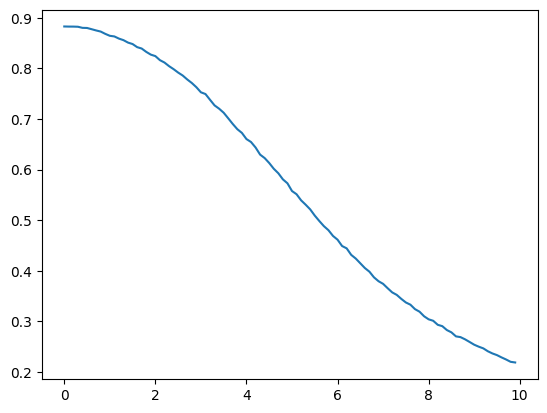

In [172]:
whole_scan_pertubate_test(46)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.80it/s]


0.7244620323181152 0.7049050331115723 0.6384812593460083


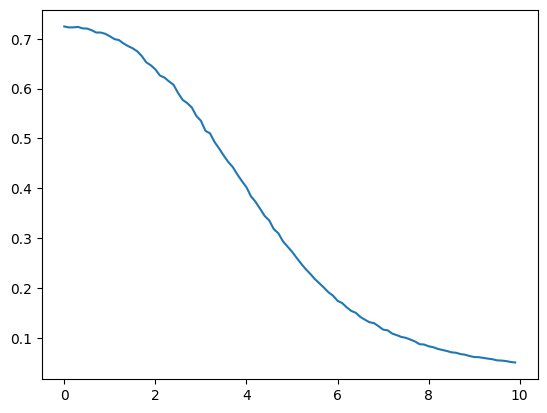

In [169]:
whole_scan_pertubate_test(30)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.94it/s]


0.4522348940372467 0.44450849294662476 0.412780225276947


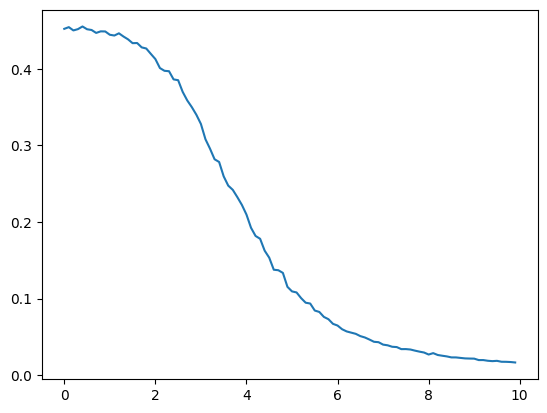

In [170]:
whole_scan_pertubate_test(55)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.61it/s]


0.4585285186767578 0.44855743646621704 0.41071876883506775


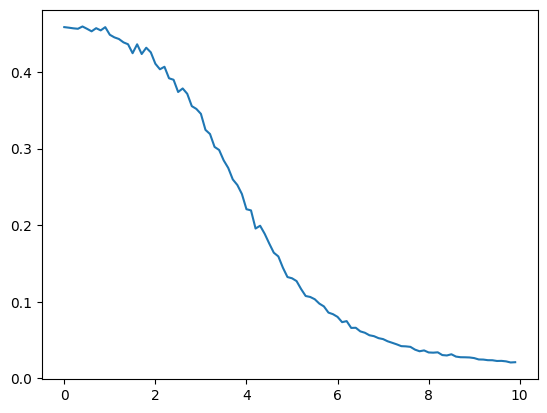

In [171]:
whole_scan_pertubate_test(42)

In [140]:
def pertubate_test(sid, islice):
    inp = means[sid][islice]

    new_dices = []
    for std in torch.arange(0, 10, 0.1):  
        out = inp + (torch.randn(inp.shape) * std)
        new_dices.append(fast_dice(out.argmax(dim=0), ys3d_test[sid][islice]))

    plt.plot(torch.arange(0, 10, 0.1), new_dices)

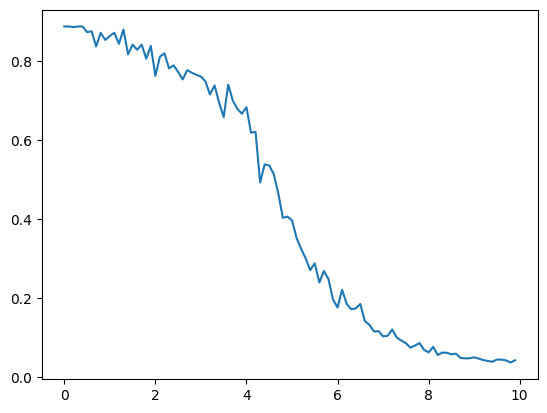

In [159]:
pertubate_test(2, 35)

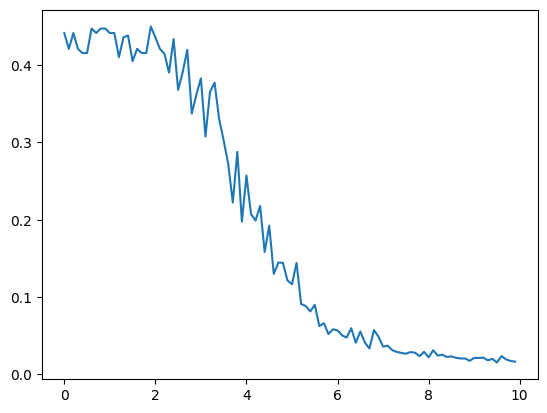

In [173]:
pertubate_test(2, 13)

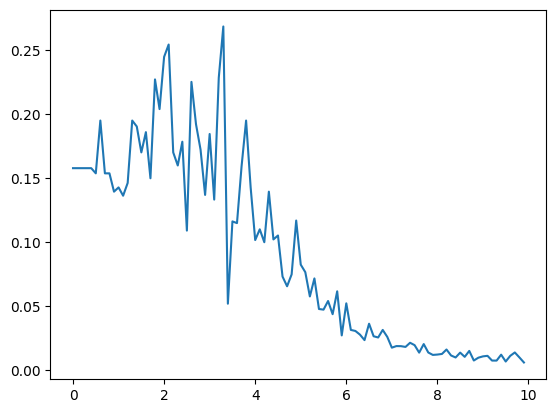

In [174]:
pertubate_test(2, 9)

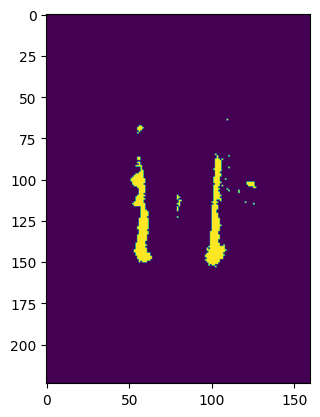

In [179]:
plt.imshow((means[0][25] + (torch.randn(2, 224, 160) * 1)).argmax(dim=0))

In [117]:
fast_dice(means[0][25].argmax(dim=0), ys3d_test[0][25])

0.835579514503479

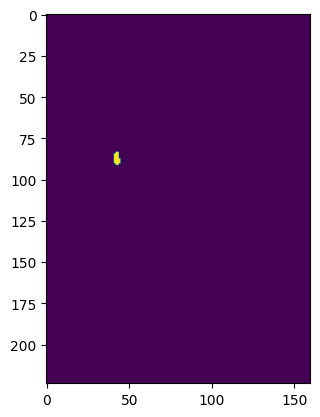

In [124]:
plt.imshow(means[2][13].argmax(dim=0))

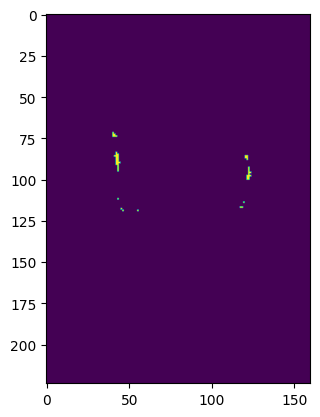

In [125]:
plt.imshow(ys3d_test[2][13])